In [1]:
import os
import glob
import numpy as np
import pandas as pd
import astropy.stats as aps
import astropy.io.fits as pf
from astropy.time import Time
import matplotlib.pyplot as plt
from skyfield.api import EarthSatellite, load

fulldata = '/Users/peter/Projects/starlink_data/full_data/'
rootdir = '/Users/peter/Projects/starlink_data/'
datadir = rootdir + 'test_data/'
savedir = rootdir + 'images/colloq_plots/'

%matplotlib inline

vmags = np.sort(glob.glob(f'{fulldata}vmags_*.p'))
errors = np.sort(glob.glob(f'{fulldata}vmag_errors_*.p'))
passages = np.sort(glob.glob(f'{fulldata}passages_*.p'))
passed = np.sort(glob.glob(f'{fulldata}passed_*.p'))
refname = pd.read_pickle(f'{fulldata}starlink_names.p')
pools = np.sort(glob.glob(f'{fulldata}pool_*.p'))

In [2]:
def get_tles():
    
    # Load TLEs for all satellite passages
    satfiles = f"{datadir}/3leComplete.txt"
    with open(satfiles) as f:
        all_tles = f.readlines()
        f.close()

    # Split TLE list into individual lists for each TLE
    all_tles = [i.strip() for i in all_tles]
    tles = [all_tles[x:x+3] for x in range(0, len(all_tles), 3)]

    # Reduce TLEs to Starlink only
    starlink_tles = []
    for tle in tles:
        if "STARLINK" in tle[0]:
            starlink_tles.append(tle)
            
    for tle in starlink_tles:
        tle[0] = tle[0][2:]
        
    return starlink_tles

In [3]:
def get_starlink_launches():
    """
    For the scraping: probably not the best way, but essentially just adds everything to a list.
    Thinking have it this way such that it just needs to be run once.
    
    """
    
    import requests
    from bs4 import BeautifulSoup
    
    base_url = 'https://nssdc.gsfc.nasa.gov/nmc/spacecraft/query'
    search_params = {'name': 'starlink'}

    # Send a GET request to the website
    response = requests.get(base_url, params=search_params)

    # Parse the HTML content of the page
    soup = BeautifulSoup(response.text, 'html.parser')

    
    # Index 0: Name         ...  Starlink 1007
    # Index 1: NSSDCA ID    ...  2019-074A
    # Index 2: Launch date  ...  2019-11-11 (Y:M:D)
    
    i=0
    names = []
    dates = []

    # Find the table rows that contain satellite data
    for row in soup.find_all('td'):
        entry = row.get_text()
        i+=1
        if i==1:
            entry = entry.upper().replace(' ', '-') #since my data is uppercase and hyphenated
            names.append(entry)
        if i==2:
            continue
        if i==3:
            dates.append(entry)
            i=0
            
    df = pd.DataFrame({'name': names, 'launch': dates})
    df['launch'] = pd.to_datetime(df['launch'])
    

    starlink_tles = get_tles()
        
        
    # DarkSat = Starlink-1130 = 44932U
    # Visors - 7 August 2020
    # Visors removed - 14 September 2021 onwards
    # V1.5 - 30 June 2021 onwards
    # V2-mini: 27 February 2023, 19 April 2023, 19 May 2023 ---> out of our date range
    
    
    df2 = pd.DataFrame(columns=['starlink', 'satnum', 'launch', 'version', 'type'])
    for i, tle in enumerate(starlink_tles):
        starlink = tle[0]
        try:
            idx = np.where(df.name.values == starlink)[0][0]
        except:
            continue
        satnum = tle[1].split()[1]
        date = df.launch.iloc[idx]
        satname = df.name.iloc[idx]

        # v0.1
        if date < pd.to_datetime('2018-02-23'):
            version = '0.1'
            sattype = 'tintin'

        # v0.9
        if date > pd.to_datetime('2018-02-23') and date < pd.to_datetime('2019-11-12'):
            version = '0.9'
            sattype = 'standard'

        # v1.0
        if date > pd.to_datetime('2019-11-12') and date < pd.to_datetime('2021-05-27'):
            version = '1.0'
            if satnum == '44932U':
                sattype = 'darksat'
            elif date > pd.to_datetime('2020-06-30'):
                sattype = 'visorsat'
            else:
                sattype = 'standard'

        # v1.5
        if date > pd.to_datetime('2021-05-27'):
            version = '1.5'
            if date < pd.to_datetime('2021-09-13'):
                sattype = 'visorsat'
            else:
                sattype = 'standard'


        row_data = [satname, satnum, date, version, sattype]
        df2.loc[len(df2)] = row_data
    
    return df2

In [4]:
def observation_info():
    
    df = get_starlink_launches()
    
    ### Timerange of observations
    for psg in passages:
        p = pd.read_pickle(psg)
        camid = psg[-5:-2]

        # JD of first observation
        lstseq0 = list(p)[0]
        sat0 = list(p[lstseq0])[0]
        jd0 = p[lstseq0][sat0]['start']['jd']

        # JD of last observation
        lstseq1 = list(p)[-1]
        sat1 = list(p[lstseq1])[0]
        jd1 = p[lstseq1][sat1]['end']['jd']

        t0 = Time(jd0, format='jd', scale='utc')
        t1 = Time(jd1, format='jd', scale='utc')
        time_diff = t1 - t0
        print(f"{camid} - time range spanned: {time_diff.to('hour')} ... {t0.iso} to {t1.iso}\n")
    
    
    ### Unique Starlinks
    
    all_sats = []
    for vmag in vmags:
        
        camid = vmag[-5:-2]
        v = pd.read_pickle(vmag)
        sats = []
        for lstseq in v:
            sats.extend(list(v[lstseq])[2:])
            
        all_sats.extend(sats)
        unique_sats = list(set(sats)) 
        print(f'{camid}: {len(sats)} observations;  {len(unique_sats)} unique starlinks')
        
    all_unique_sats = list(set(all_sats))
    print(f'\n{len(all_sats)} total observations  -  {len(all_unique_sats)} unique Starlinks\n')
    
    
    ### Type of Starlinks
    
    version = []
    sat_types = []
    for satnum in all_sats:
        sat_types.append(df.loc[df['satnum'] == satnum].type.values[0])
        version.append(df.loc[df['satnum'] == satnum].version.values[0])
    

    version_unique = []    
    sat_types_unique = []
    for satnum in all_unique_sats:
        sat_types_unique.append(df.loc[df['satnum'] == satnum].type.values[0])
        version_unique.append(df.loc[df['satnum'] == satnum].version.values[0])
        
    print(f"Standard:   {sat_types.count('standard')}  -   {sat_types_unique.count('standard')}")
    print(f"VisorSat:   {sat_types.count('visorsat')}   -   {sat_types_unique.count('visorsat')}")
    print(f"DarkSats:   {sat_types.count('darksat')}     -   {sat_types_unique.count('darksat')}\n")
    
    
    # Total
    count = {}
    x = list(zip(sat_types, version))
    print('For all observations:\n')
    for elem in x:
        key = elem[0] 
        val = elem[1]   
        if key in count:
            inner = count[key]
        else:
            inner= {}
            count[key] = inner  
        if val in inner:
            inner[val] += 1
        else:
            inner[val] = 1
            
    for key, inner in count.items():
        print(key + ":")
        for val, count in inner.items():
            print(f"  {val}: {count}")
            
    print('\n')
    
    # Unique
    count = {}
    x = list(zip(sat_types_unique, version_unique))
    print('For unique observations:\n')
    for elem in x:
        key = elem[0] 
        val = elem[1]   
        if key in count:
            inner = count[key]
        else:
            inner= {}
            count[key] = inner  
        if val in inner:
            inner[val] += 1
        else:
            inner[val] = 1
            
    for key, inner in count.items():
        print(key + ":")
        for val, count in inner.items():
            print(f"  {val}: {count}")
    
    

In [5]:
observation_info()

LSC - time range spanned: 8.65719048678875 h ... 2022-10-24 00:23:19.418 to 2022-10-24 09:02:45.304

LSE - time range spanned: 8.65719049796462 h ... 2022-10-24 00:23:19.418 to 2022-10-24 09:02:45.304

LSN - time range spanned: 8.657191067934036 h ... 2022-10-24 00:23:19.417 to 2022-10-24 09:02:45.305

LSS - time range spanned: 8.657190531492233 h ... 2022-10-24 00:23:19.419 to 2022-10-24 09:02:45.305

LSW - time range spanned: 8.657190799713135 h ... 2022-10-24 00:23:19.418 to 2022-10-24 09:02:45.305

LSC: 164 observations;  36 unique starlinks
LSE: 426 observations;  67 unique starlinks
LSN: 110 observations;  20 unique starlinks
LSS: 448 observations;  65 unique starlinks
LSW: 457 observations;  64 unique starlinks

1605 total observations  -  176 unique Starlinks

Standard:   1247  -   118
VisorSat:   356   -   57
DarkSats:   2     -   1

For all observations:

visorsat:
  1.0: 356
standard:
  1.5: 671
  1.0: 453
  0.9: 123
darksat:
  1.0: 2


For unique observations:

standard:
  

In [6]:
def reduce_passages(camid):
    
    all_passages = pd.read_pickle(f'{fulldata}passages_20221023{camid}.p')
    pool = pd.read_pickle(f'{fulldata}pool_{camid}.p')

    passages = {}
    for lstseq, data in all_passages.items():
        if lstseq in pool:
            passages[lstseq] = {}
            for satnum in pool[lstseq]:
                if satnum in data:
                    passages[lstseq][satnum] = data[satnum]
                    
    return passages

In [7]:
from skyfield.units import Angle
from skyfield.api import load, wgs84, EarthSatellite 

eph = load('de421.bsp')

def get_siteinfo():
    confdir = '/Users/Peter/Projects/starlink_data/fotos-python3/bringfiles/siteinfo.dat'
    dtype = [('sitename', '|U20'), ('lat', 'float32'), ('lon', 'float32'), ('height', 'float32'), ('ID', '|U2')]
    siteinfo = np.genfromtxt(confdir, dtype=dtype)   
    mask = siteinfo['ID'] == 'LS'
    siteinfo = siteinfo[mask]
    return siteinfo

In [8]:
def error_prop(flux, sigma_F, sigma_B):
    dm_dF = -2.5/(flux*np.log(10))
    dm_dB = 1
    return np.sqrt((dm_dF*sigma_F)**2 + (dm_dB*sigma_B)**2)


def compute_vmag_errors():
    
    all_vmags  = []
    all_deltas = []
    camids = ['LSC','LSN','LSS','LSE','LSW']
    
    sigma_F = 0.08658855727735504
    
    for camid in camids:
        vmags = pd.read_pickle(f'{fulldata}vmags_{camid}.p')
        
        for lstseq in vmags.keys():
            for sat in list(vmags[lstseq])[2:]:
                vmag = vmags[lstseq][sat]['vmag']
                flux = vmags[lstseq][sat]['flux']
                sigma_B = vmags[lstseq][sat]['sigma_B']
                delta = error_prop(flux, sigma_F, sigma_B)
                
                all_vmags.append(vmag)
                all_deltas.append(delta)
                        
    return all_vmags, all_deltas

In [9]:
all_vmags, all_deltas = compute_vmag_errors()

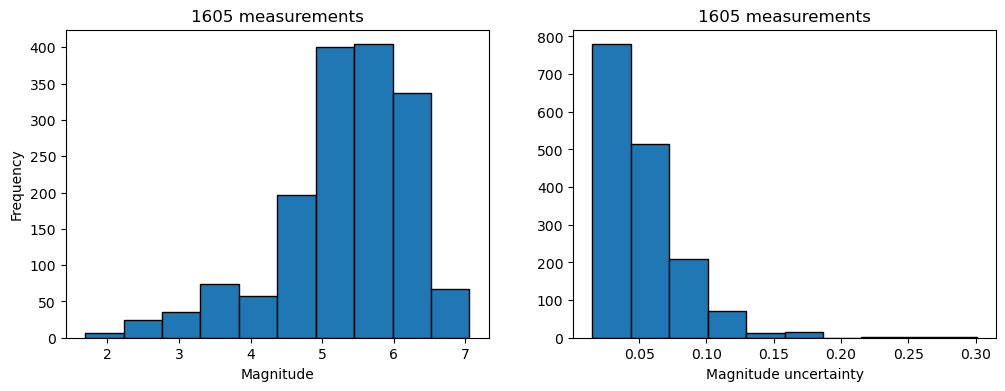

In [10]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[12,4])

ax1.hist(all_vmags, ec='k')
ax1.set_title(f'{len(all_vmags)} measurements')
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('Frequency')

ax2.hist(all_deltas, ec='k')
ax2.set_title(f'{len(all_deltas)} measurements')
ax2.set_xlabel('Magnitude uncertainty')

plt.show()

# Range normalized magnitudes

# Definitive dataframe with everything .. (should have done from the start!)

In [11]:
def combine_dataframes():
    
    # ALL IMPORTANT INFO IN ONE DATAFRAME!!!
    
    d = {}
    vmag_files = sorted(glob.glob(f'{fulldata}vmags_*'))
    sigma_F = 0.08658855727735504
    
    satinfo = get_starlink_launches()
    
    for file in vmag_files:
        camid = file[-5:-2]
        vmags = pd.read_pickle(file)
        
        all_sats = []
        for lstseq in vmags:
            all_sats.extend(list(vmags[lstseq])[2:])
        sats = list(set(all_sats)) 

        # Creating a dictionary where each key is a unique satellite
        satdict = {}
        for satnum in sats:
            satdict[satnum] = {
                'satname':[], 'vmag':[], 'delta':[], 'jd0':[], 'jd1':[], 
                'camid':[], 'type':[], 'version':[], 'launch':[]
            }
        
        for lstseq in vmags:
            satnums = list(vmags[lstseq])[2:]
            for satnum in satnums:
                if satnum in satdict.keys():
                    
                    jd0 = vmags[lstseq]['JD0']
                    jd1 = vmags[lstseq]['JD1']
                    vmag = vmags[lstseq][satnum]['vmag']
                    satname = vmags[lstseq][satnum]['name']
                    
                    flux = vmags[lstseq][satnum]['flux']
                    sigma_B = vmags[lstseq][satnum]['sigma_B']
                    delta = error_prop(flux, sigma_F, sigma_B)
                    
                    launch = satinfo.loc[satinfo['satnum'] == satnum].launch.values[0]
                    sattype = satinfo.loc[satinfo['satnum'] == satnum].type.values[0]
                    version = satinfo.loc[satinfo['satnum'] == satnum].version.values[0]

                    satdict[satnum]['jd0'].append(jd0)
                    satdict[satnum]['jd1'].append(jd1)                                        
                    satdict[satnum]['vmag'].append(vmag)
                    satdict[satnum]['delta'].append(delta)
                    satdict[satnum]['camid'].append(camid)
                    satdict[satnum]['type'].append(sattype)
                    satdict[satnum]['launch'].append(launch)
                    satdict[satnum]['version'].append(version)
                    satdict[satnum]['satname'].append(satname)
                    
            
        d[camid] = pd.DataFrame([
            (satnum, satname, vmag, delta, jd0, jd1, camid, sattype, version, launch) \
            for satnum, vals in satdict.items() \
            for satname, vmag, delta, jd0, jd1, camid, sattype, version, launch in zip(
                vals['satname'], vals['vmag'], vals['delta'], vals['jd0'], vals['jd1'], 
                vals['camid'], vals['type'], vals['version'], vals['launch']
            )], columns=['satnum', 'satname', 'vmag', 'delta', 'JD0', 'JD1', 'camid', 'type', 'version', 'launch']
        )
    
    df = pd.concat(d.values(), ignore_index=True)
    return df

In [12]:
original_df = combine_dataframes()

In [13]:
def orbital_params(df):
    
    starlink_tles = get_tles() 
    eph = load('de421.bsp')
    sun = eph['sun']
    earth = eph['earth']
    
    ts = load.timescale()
    site = get_siteinfo()
    mascara = wgs84.latlon(latitude_degrees=site[0][1], longitude_degrees=site[0][2], elevation_m=site[0][3])
    observer = mascara + earth
    
        
    for index, row in df.iterrows():
        satnum = row.satnum
        vmag = row.vmag
        JD = row.JD1
        t = Time(JD, format='jd')
        
        for i, tle in enumerate(starlink_tles):
            if satnum in tle[1]:
                
                sat = EarthSatellite(tle[1], tle[2], tle[0], ts) 
                obs_time = ts.from_astropy(t)
                
                # Phase Angle
                obs_sat = earth + sat
                topo_sat_obs = obs_sat.at(obs_time).observe(observer).apparent()
                topo_sat_sun = obs_sat.at(obs_time).observe(sun).apparent() 
                phase_angle = topo_sat_obs.separation_from(topo_sat_sun)
                
                # Inclination
                inc = sat.model.inclo
                inc = Angle(radians=inc).degrees
                
                # Position
                diff = sat - mascara
                topocentric = diff.at(obs_time)
                alt, az, dist = topocentric.altaz()
                ra, dec, _ = topocentric.radec() 
                #phase_angle = np.degrees(np.arctan2(alt.radians, az.radians))
                
                # Height
                geocentric = sat.at(obs_time)
                height = wgs84.height_of(geocentric)

                df.loc[index, 'inc'] = inc
                df.loc[index, 'phase_angle'] = phase_angle.degrees
                df.loc[index, 'height'] = height.km
                df.loc[index, 'alt'] = alt.degrees
                df.loc[index, 'az'] = az.degrees
                df.loc[index, 'ra'] = ra.hours
                df.loc[index, 'dec'] = dec.degrees
                df.loc[index, 'range'] = dist.km
                
                break         
                
    # Normalize the magnitudes to a fixed range of 550 km
    # THIS IS NOT A LINEAR ADJUSTMENT!
    # The factor for adjusting the apparent magnitudes from the actual range to a standard distance 
    # determined based on the inverse square law of light!
    
    factor = (df['height'] / 550.) ** 2
    df['vmag_norm'] = df['vmag'] + 2.5 * np.log10(factor)
    df['delta_norm'] = np.sqrt(df['delta']**2 + (2.5 * np.log10(factor) * np.log(10) * df['delta'])**2)
    
    # Zwicky scaling:
#     df['new_vmag_norm'] = df['vmag'] - 5 * np.log10(df['height']/550.)

    #df['vmag_norm'] = df['vmag'] * (550 / df['height'])
    #df['delta_norm'] = df['delta'] * (550 / df['height'])

    return df

In [14]:
df = orbital_params(original_df)

In [15]:
df[['vmag', 'vmag_norm', 'height', 'delta', 'delta_norm', 'phase_angle']].head()

,vmag,vmag_norm,height,delta,delta_norm,phase_angle
0,5.143112,5.169851,556.814572,0.027722,0.027775,80.562489
1,5.921139,5.947408,556.693950,0.034098,0.034160,76.203980
2,5.001684,5.001404,549.928868,0.019857,0.019857,93.777395
3,5.672759,5.672933,550.044151,0.057543,0.057543,92.682060
4,5.578851,5.579480,550.159429,0.040766,0.040766,91.574501


36
20
65
67
64


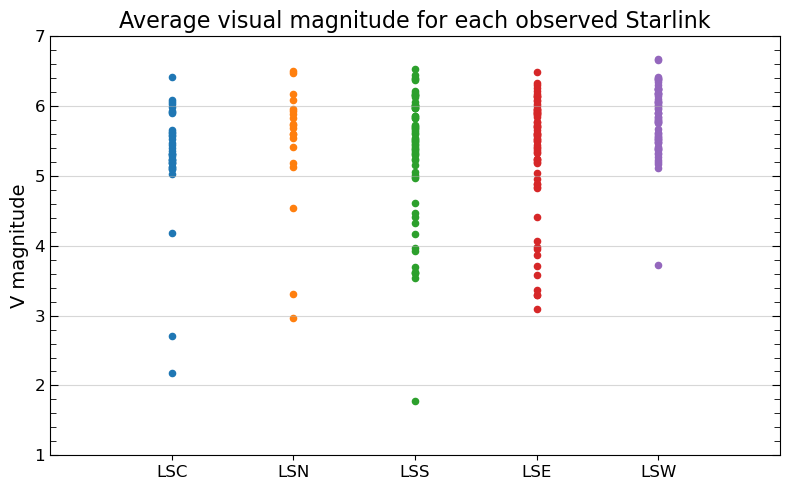

In [16]:
def avf_mag_cam():
    
    fig, ax = plt.subplots(1, 1, figsize=[8,5])

    camids = ['LSC', 'LSN', 'LSS', 'LSE', 'LSW']
    for i, camid in enumerate(camids):

        vmags = []
        subset = df[df['camid']==camid][['satnum', 'vmag']]

        for satnum in subset.satnum.unique():
            sat_vmag = np.mean(subset[subset['satnum']==satnum].vmag.values)
            vmags.append(sat_vmag)

        print(len(vmags))
        ax.scatter(np.ones(len(vmags))+i, vmags, s=20)

    ax.set_xticks([1,2,3,4,5], camids)
    ax.set_ylim([1, 7])
    ax.set_xlim([0, 6])
    ax.set_title('Average visual magnitude for each observed Starlink', fontsize=16)
    ax.set_ylabel('V magnitude', fontsize=14)

    ax.tick_params(axis='y', which='both', right=True, direction='in')
    ax.tick_params(axis='y', which='major', length=6)
    ax.tick_params(axis='y', which='minor', length=4)
    ax.yaxis.get_ticklocs(minor=True)
    ax.minorticks_on()
    ax.xaxis.set_tick_params(which='minor', bottom=False)
    ax.yaxis.grid(alpha=0.5)

    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    # plt.savefig('avg_vmags.png', dpi=300, bbox_inches='tight', facecolor='w')
    plt.show()
    
avf_mag_cam()

In [22]:
# beg=48506263, end=48511144
# N_lstseqs=4881

# LSC 48506263 48511144 4492

def affected_images():
    
    fig, axs = plt.subplots(2, 3, figsize=[12,6], sharex=True)
    props = dict(boxstyle='round', facecolor='w')
    
    camids = ['LSC', 'LSN', 'LSS', 'LSE', 'LSW']
    for ax, camid in zip(axs.ravel()[1:], camids):
        
        p = pd.read_pickle(f'{fulldata}passages_20221023{camid}.p')
        beg = int(list(p.keys())[0])
        end = int(list(p.keys())[-1])
        N_lstseqs = 4881
        print(camid, beg, end, N_lstseqs)

        x = N_lstseqs * 6.4
        bin_width = 60 # spacing by 64 seconds
        N = int(np.ceil(x / bin_width)) # Number of bins 

        all_images = np.arange(beg, end+1, 1)
        combined_counts = [0] * N
        all_indices = 0
        bin_counts = [0] * N  # Initialize count for each bin
    
        indices = []
        vmags = pd.read_pickle(f'{fulldata}vmags_{camid}.p')
        for lstseq in list(vmags):
            num = int(lstseq)
            index = np.where(all_images == num)[0][0]
            indices.append(index)

        for idx in indices:
            bin_number = (idx + 1)*6.4            
            bin_idx = int(bin_number / bin_width)  # Determine the bin index
            
            bin_counts[bin_idx] += 1 # Increment the count for the corresponding bin
            combined_counts[bin_idx] += 1
            
        # Generate the interval boundaries  
        bin_edges = [i * bin_width / 60 - bin_width / 120 for i in range(N)] 
        
        # (- bin_width / 120) shifts the bars to start from an x-axis value of 0 while being aligned 
        # with the left edge of each bin. By subtracting bin_width/2 from each bin_edges value, you 
        # shift the bars to start from an x-axis value of 0. 60 is for conversion to minutes
        
#         # Fraction of images affected
#         frac = round(len(indices)/len(vmags), 2)
#         all_indices += len(indices)
        
        ax.bar(bin_edges, bin_counts, width=bin_width / 60, align='edge', color='C2', alpha=0.5)
        ax.tick_params(which='both', direction='in', top=True, right=True)
#         ax.text(0.1, 0.075, f'{camid}', fontsize=16, transform=ax.transAxes)
#         ax.text(0.8, 0.85, frac, transform=ax.transAxes, fontsize=14, va='center', bbox=props)
        
        
    ax_combined = axs[0, 0]
    ax_combined.bar(bin_edges, combined_counts, width=bin_width / 60, align='edge', color='C2', alpha=0.5)
    ax_combined.tick_params(which='both', direction='in', top=True, right=True)
    ax_combined.set_ylabel('# images affected', fontsize=12)
#     ax_combined.text(0.1, 0.075, 'Combined', fontsize=16, transform=ax_combined.transAxes)
    
#     total_frac = round(all_indices/(467*5), 2)
#     ax_combined.text(0.8, 0.85, total_frac, transform=ax_combined.transAxes, fontsize=14, va='center', bbox=props)
    
    axs[1,0].set_ylabel('# images affected', fontsize=12)
    for ax in axs.ravel()[3:]:
        ax.set_xlabel('Time [minutes]', fontsize=12)
    
    fig.suptitle('Bin width = 64 seconds', fontsize=16)
    plt.tight_layout()
    #plt.savefig('affected_images.png', facecolor='w', bbox_inches='tight', dpi=300)
    plt.show()

In [24]:
# affected_images()

In [ ]:
# # beg=48506263, end=48511144
# # N_lstseqs=4881

# # LSC 48506263 48511144 4492

# def affected_images():
    
#     fig, axs = plt.subplots(2, 3, figsize=[12,6], sharex=True)
#     props = dict(boxstyle='round', facecolor='w')
    
#     jd_sorted = sorted(df[df['camid']==camid])
#     t0 = Time(jd_sorted.jd0.values[0], format='jd')
#     t1 = Time(jd_sorted.jd0.values[-1], format='jd')
#     time_range = np.arange(t0.jd, t1.jd, 600 / (24 * 60 * 60))
#     times = Time(time_range, format='jd')
    
#     axs[0,0].hist(times.datetime, weights=satnums, fc='None')
    
#     camids = ['LSC', 'LSN', 'LSS', 'LSE', 'LSW']
#     for ax, camid in zip(axs.ravel()[1:], camids):
        
#         p = pd.read_pickle(f'{fulldata}passages_20221023{camid}.p')
#         jd = df[df['camid']==camid].jd0.values
#         t0 = Time(jd[0], format='jd')
#         t1 = Time(jd[-1], format='jd')
#         time_range = np.arange(t0.jd, t1.jd, 600 / (24 * 60 * 60))
#         times = Time(time_range, format='jd')
#         ax.hist(times.datetime, bins=30, weights=vmags, fc='None')
        
        
    
#     axs[1,0].set_ylabel('# images affected', fontsize=12)
#     for ax in axs.ravel()[3:]:
#         ax.set_xlabel('Time [minutes]', fontsize=12)
    
#     fig.suptitle('Bin width = 64 seconds', fontsize=16)
#     plt.tight_layout()
#     #plt.savefig('affected_images.png', facecolor='w', bbox_inches='tight', dpi=300)
#     plt.show()

In [43]:
def hist_sattypes():
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[10,4])
        
            
    n_bins = 50          
    ax1.hist(df[df.type=='standard'].vmag.values, n_bins, color='C1', ec='grey', alpha=0.7)
    ax2.hist(df[df.type=='visorsat'].vmag.values, n_bins, color='C1', ec='grey', alpha=0.7)
    
    ax1.set_title('Standard Starlinks')
    ax2.set_title('Visored Starlinks')
    
    for ax in [ax1, ax2]:
        #ax.tick_params(axis='y', which='both', right=True, direction='in')
        ax.tick_params(which='both', direction='in', top=True, right=True)
        ax.tick_params(axis='both', which='major', length=6)
        ax.tick_params(axis='x', which='minor', length=4)
        ax.yaxis.get_ticklocs(minor=True)
        ax.minorticks_on()
        #ax.xaxis.set_ticxk_params(which='minor', bottom=False)
        ax.set_xlabel('V magnitude')
        
    plt.tight_layout()
    plt.show()

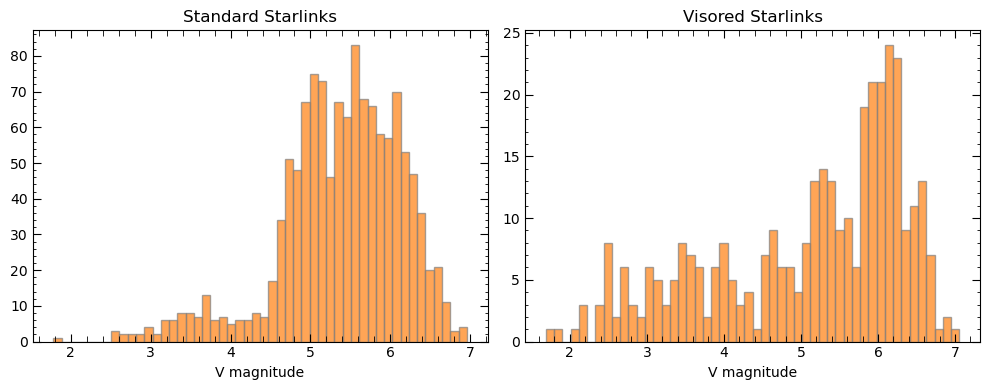

In [44]:
hist_sattypes()

In [57]:
def hist_sattypes_all():
    import matplotlib.ticker as ticker
    fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=[12,8], sharex=False)
    
    stand = df[df.type=='standard'].vmag.values
    visor = df[df.type=='visorsat'].vmag.values
    dark = df[df.type=='darksat'].vmag.values
                        
    n_bins = 10   
    ax1.hist(df.vmag.values, n_bins, fc='C0', ec='k', zorder=2)
    ax2.hist(stand, n_bins, fc='C0', ec='k', zorder=2)
    ax3.hist(visor, n_bins, fc='C0', ec='k', zorder=2)
    ax4.hist(dark, 2, fc='C0', ec='k', zorder=2)
    
    print('All: ', len(df.vmag.values), '; mean =', np.mean(df.vmag.values))
    print('Standard: ', len(stand), '; mean =', np.mean(stand))
    print('VisorSat: ', len(visor), '; mean =', np.mean(visor))
    print('DarkSat: ', len(dark), '; mean =', np.mean(dark))
    
    for ax in [ax1, ax2, ax3]:
        ax.minorticks_on()
        ax.set_xlim(ax1.get_xlim())
        ax.tick_params(axis='both', direction='in', top=True, right=True)
        ax.tick_params(axis='both', which='major', length=7, labelsize=16)
        ax.tick_params(axis='both', which='minor', direction='in', right=True, top=True, length=4)
        ax.yaxis.get_ticklocs(minor=True)
        ax.grid(alpha=0.5, which='both', zorder=1)
        ax.grid(which='minor', alpha=0.1, zorder=1)
    
    ax1.set_ylabel('Count', labelpad=10, fontsize=20)
    ax3.set_ylabel('Count', labelpad=10, fontsize=20)
    ax3.set_xlabel(r'm$_v$', fontsize=20)
    ax4.set_xlabel(r'm$_v$', fontsize=20)  
    
    ax4.minorticks_on()
    ax4.yaxis.set_major_locator(ticker.FixedLocator([0, 1]))
    ax4.set_yticklabels([0,1])
    ax4.set_xlim(ax1.get_xlim())
    ax4.set_ylim([0,1.1])
    ax4.tick_params(axis='both', direction='in', top=True, right=True)
    ax4.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax4.tick_params(axis='x', which='minor', length=4)
    ax4.tick_params(axis='y', which='minor', left=False, right=False)
    ax4.tick_params(axis='x', which='minor', top=True, direction='in')
    ax4.grid(alpha=0.5, which='both', zorder=1)
    ax4.grid(which='minor', alpha=0.1, zorder=1)

#     plt.tight_layout()
#     plt.savefig(f'{savedir}vmag_hist.png', bbox_inches='tight', dpi=300)
    plt.show()

All:  1605 ; mean = 5.316642710620059
Standard:  1247 ; mean = 5.380386107768826
VisorSat:  356 ; mean = 5.088151646090843
DarkSat:  2 ; mean = 6.244044074564632


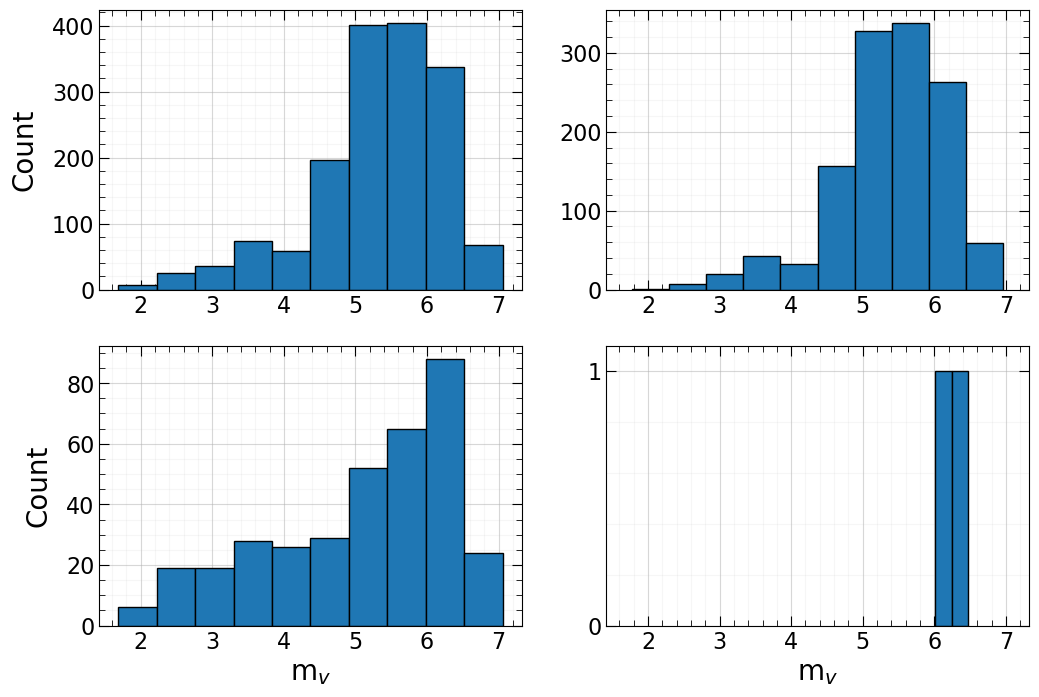

In [58]:
hist_sattypes_all()

All:  1247 ; mean = 5.380386107768826
v0.9:  123 ; mean = 5.459786052466993
v1.0:  453 ; mean = 5.369271740865904
v1.5:  671 ; mean = 5.373334863371134


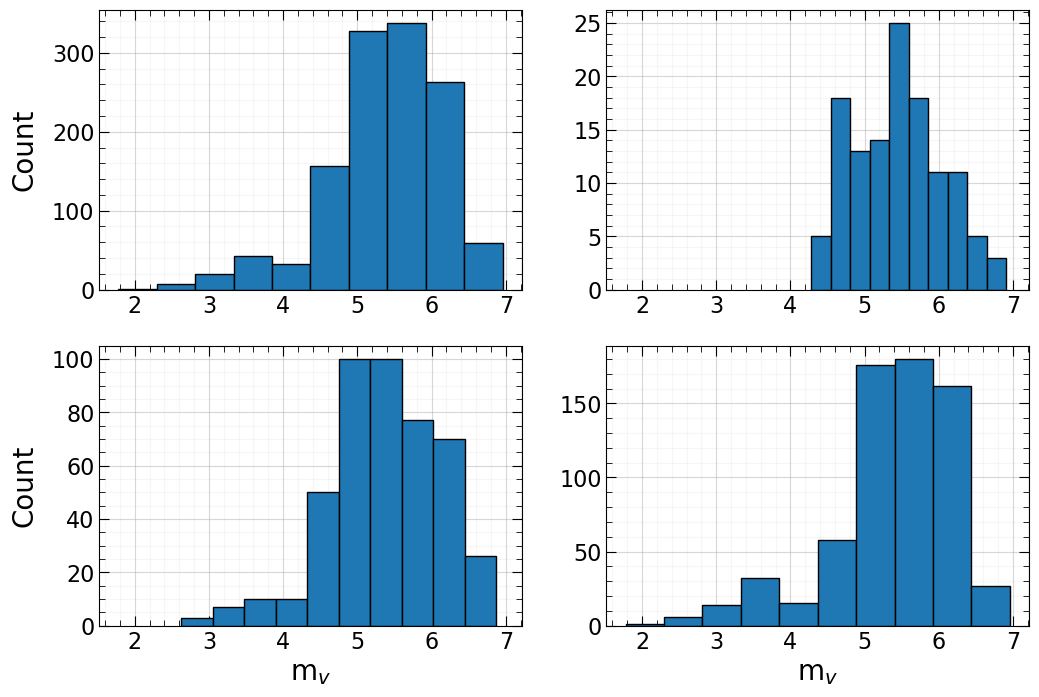

In [56]:
def hist_standard_versions():
    import matplotlib.ticker as ticker
    fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=[12,8], sharex=False)

    stan = df[df.type=='standard']           
    n_bins = 10   
    
    v09 = stan[stan.version=='0.9'].vmag.values
    v10 = stan[stan.version=='1.0'].vmag.values
    v15 = stan[stan.version=='1.5'].vmag.values
    ax1.hist(stan.vmag.values, n_bins, fc='C0', ec='k', zorder=2)
    ax2.hist(v09, fc='C0', ec='k', zorder=2)
    ax3.hist(v10, fc='C0', ec='k', zorder=2)
    ax4.hist(v15, fc='C0', ec='k', zorder=2)
    
    print('All: ', len(stan.vmag.values), '; mean =', np.mean(stan.vmag.values))
    print('v0.9: ', len(v09), '; mean =', np.mean(v09))
    print('v1.0: ', len(v10), '; mean =', np.mean(v10))
    print('v1.5: ', len(v15), '; mean =', np.mean(v15))
    
    for ax in [ax1, ax2, ax3, ax4]:
        ax.minorticks_on()
        ax.set_xlim(ax1.get_xlim())
        ax.tick_params(axis='both', direction='in', top=True, right=True)
        ax.tick_params(axis='both', which='major', length=7, labelsize=16)
        ax.tick_params(axis='both', which='minor', direction='in', right=True, top=True, length=4)
        ax.yaxis.get_ticklocs(minor=True)
        ax.grid(alpha=0.5, which='both', zorder=1)
        ax.grid(which='minor', alpha=0.1, zorder=1)
    
    ax1.set_ylabel('Count', labelpad=10, fontsize=20)
    ax3.set_ylabel('Count', labelpad=10, fontsize=20)
    ax3.set_xlabel(r'm$_v$', fontsize=20)
    ax4.set_xlabel(r'm$_v$', fontsize=20)  

#     plt.tight_layout()
#     plt.savefig(f'{savedir}vmag_hist.png', bbox_inches='tight', dpi=300)
    plt.show()
    
hist_standard_versions()

## Uncertainty for means

Calculate the average of the brightness magnitudes.

Calculate the standard deviation of the individual brightness magnitude uncertainties.

Divide the standard deviation by the square root of the number of data points (n) to obtain the standard error of the mean (SEM). The formula is SEM = σ / √(n), where σ is the standard deviation of the individual uncertainties.

The uncertainty for the average value is given by the SEM, which represents the precision of the mean value.

To clarify, you should calculate the standard deviation of the individual brightness magnitude uncertainties, not the magnitudes themselves. The standard deviation of the uncertainties quantifies the spread or variability in the reliability of the measurements, which is then used to determine the uncertainty for the average value.

All:  1247 ; mean = 5.380386107768826 ; delta = 0.030518462280221766
v0.9:  123 ; mean = 5.459786052466993 ; delta = 0.020176630646838098
v1.0:  453 ; mean = 5.369271740865904 ; delta = 0.031031445183710735
v1.5:  671 ; mean = 5.373334863371135 ; delta = 0.031617233736487164


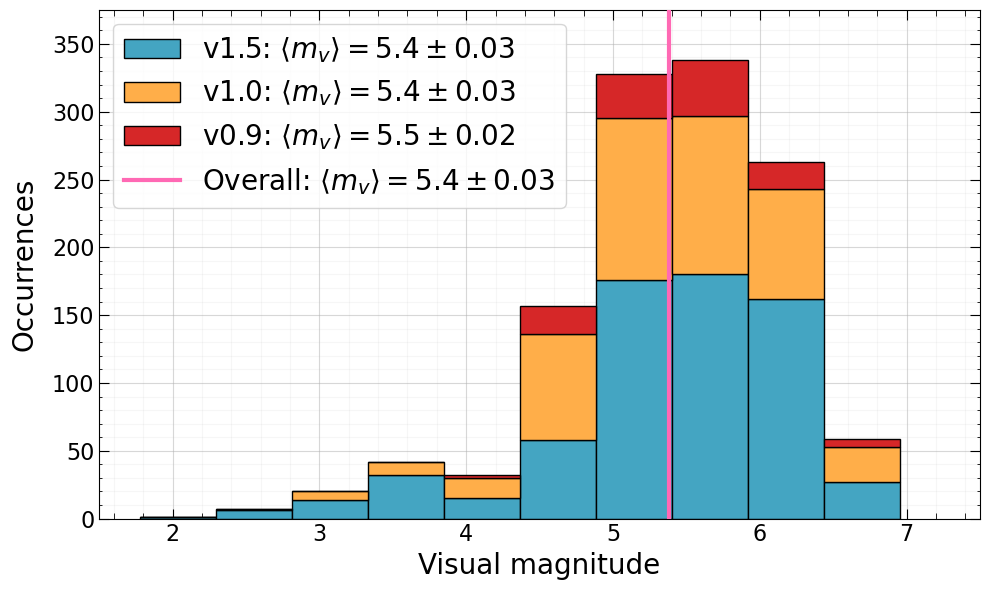

In [26]:
def hist_stacked_versions():
    
    import matplotlib.ticker as ticker
    fig, ax = plt.subplots(1, 1, figsize=[10,6])

    n_bins = 10  
    stan = df[df.type=='standard']           
    v09 = stan[stan.version=='0.9'].vmag.values
    v10 = stan[stan.version=='1.0'].vmag.values
    v15 = stan[stan.version=='1.5'].vmag.values
    v09d = stan[stan.version=='0.9'].delta.values
    v10d = stan[stan.version=='1.0'].delta.values
    v15d = stan[stan.version=='1.5'].delta.values
    
    print('All: ', len(stan.vmag.values), '; mean =',np.mean(stan.vmag.values), '; delta =',np.std(stan.delta.values))
    print('v0.9: ', len(v09), '; mean =', np.mean(v09), '; delta =', np.std(v09d))
    print('v1.0: ', len(v10), '; mean =', np.mean(v10), '; delta =', np.std(v10d))
    print('v1.5: ', len(v15), '; mean =', np.mean(v15), '; delta =', np.std(v15d))
    cols = ['#44a5c2', '#ffae49', 'C3' ]
    labs = [r'v1.5: $\langle m_v \rangle = {} \pm {}$'.format(round(np.mean(v15),1), round(np.std(v15d),2)),
            r'v1.0: $\langle m_v \rangle = {} \pm {}$'.format(round(np.mean(v10),1), round(np.std(v10d),2)),
            r'v0.9: $\langle m_v \rangle = {} \pm {}$'.format(round(np.mean(v09),1), round(np.std(v09d),2))]
    
    #ax.hist([v09,v10,v15], bins=n_bins, color=cols, label=labs, ec='k', stacked=True)
    ax.hist([v15,v10,v09], bins=n_bins, color=cols, label=labs, ec='k', stacked=True, zorder=2)
    ax.grid(alpha=0.5, which='both', zorder=1)
    ax.grid(which='minor', alpha=0.1, zorder=1)
    
    ax.axvline(np.mean(stan.vmag.values), c='hotpink', lw=3, zorder=3,
               label=r'Overall: $\langle m_v \rangle = {} \pm {}$'.format(
                   round(np.mean(stan.vmag.values),1), round(np.std(stan.delta.values),2)))
    
    ax.legend(fontsize=20, frameon=True)

    ax.minorticks_on()
    ax.tick_params(axis='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='x', which='minor', length=4)
    ax.tick_params(axis='y', which='minor', direction='in', right=True)
    ax.yaxis.get_ticklocs(minor=True)
    ax.tick_params(axis='x', which='minor', top=True, direction='in')
    
    ax.set_ylabel('Occurrences', labelpad=10, fontsize=20)
    ax.set_xlabel(r'Visual magnitude', fontsize=20)
    
    ax.set_xlim([1.5, 7.5])
    ax.set_ylim([0, 375])  
    
#     sem_all = np.std(stan.vmag.values)/np.sqrt(len(stan.vmag.values))
#     sem_v09 = np.std(v09)/np.sqrt(len(v09))
#     sem_v10 = np.std(v10)/np.sqrt(len(v10))
#     sem_v15 = np.std(v15)/np.sqrt(len(v15))

#     sem_all = np.sqrt(np.sum(stan.delta.values**2))
#     sem_v09 = np.sqrt(np.sum(v09d**2))
#     sem_v10 = np.sqrt(np.sum(v10d**2))
#     sem_v15 = np.sqrt(np.sum(v15d**2))

    
#     print(sem_all)
#     print(sem_v09)
#     print(sem_v10)
#     print(sem_v15)

    plt.tight_layout()
    plt.savefig(f'{savedir}hist_stacked_versions.png', bbox_inches='tight', dpi=300)
    plt.show()
    
hist_stacked_versions()

All:  1247 ; mean = 5.380386107768826 ; delta = 0.030518462280221766
v0.9:  123 ; mean = 5.459786052466993 ; delta = 0.020176630646838098
v1.0:  453 ; mean = 5.369271740865904 ; delta = 0.031031445183710735
v1.5:  671 ; mean = 5.373334863371135 ; delta = 0.031617233736487164


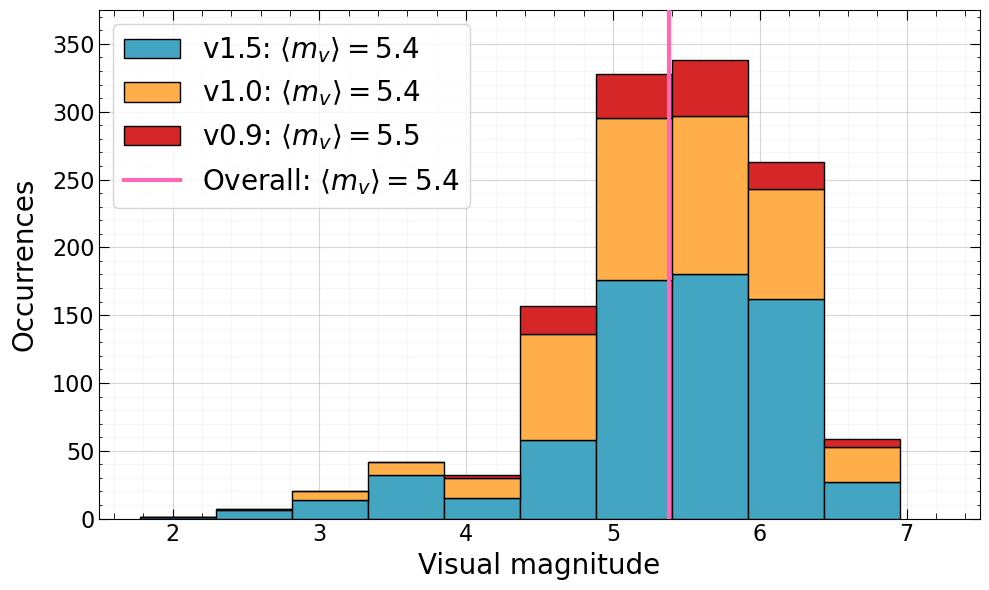

In [29]:
def hist_stacked_versions():
    
    import matplotlib.ticker as ticker
    fig, ax = plt.subplots(1, 1, figsize=[10,6])

    n_bins = 10  
    stan = df[df.type=='standard']           
    v09 = stan[stan.version=='0.9'].vmag.values
    v10 = stan[stan.version=='1.0'].vmag.values
    v15 = stan[stan.version=='1.5'].vmag.values
    v09d = stan[stan.version=='0.9'].delta.values
    v10d = stan[stan.version=='1.0'].delta.values
    v15d = stan[stan.version=='1.5'].delta.values
    
    print('All: ', len(stan.vmag.values), '; mean =',np.mean(stan.vmag.values), '; delta =',np.std(stan.delta.values))
    print('v0.9: ', len(v09), '; mean =', np.mean(v09), '; delta =', np.std(v09d))
    print('v1.0: ', len(v10), '; mean =', np.mean(v10), '; delta =', np.std(v10d))
    print('v1.5: ', len(v15), '; mean =', np.mean(v15), '; delta =', np.std(v15d))
    cols = ['#44a5c2', '#ffae49', 'C3' ]
    labs = [r'v1.5: $\langle m_v \rangle = {}$'.format(round(np.mean(v15),1)),
            r'v1.0: $\langle m_v \rangle = {}$'.format(round(np.mean(v10),1)),
            r'v0.9: $\langle m_v \rangle = {}$'.format(round(np.mean(v09),1))]
    
    #ax.hist([v09,v10,v15], bins=n_bins, color=cols, label=labs, ec='k', stacked=True)
    ax.hist([v15,v10,v09], bins=n_bins, color=cols, label=labs, ec='k', stacked=True, zorder=2)
    ax.grid(alpha=0.5, which='both', zorder=1)
    ax.grid(which='minor', alpha=0.1, zorder=1)
    
    ax.axvline(np.mean(stan.vmag.values), c='hotpink', lw=3, zorder=3,
               label=r'Overall: $\langle m_v \rangle = {}$'.format(
                   round(np.mean(stan.vmag.values),1)))
    
    ax.legend(fontsize=20, frameon=True)

    ax.minorticks_on()
    ax.tick_params(axis='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='x', which='minor', length=4)
    ax.tick_params(axis='y', which='minor', direction='in', right=True)
    ax.yaxis.get_ticklocs(minor=True)
    ax.tick_params(axis='x', which='minor', top=True, direction='in')
    
    ax.set_ylabel('Occurrences', labelpad=10, fontsize=20)
    ax.set_xlabel(r'Visual magnitude', fontsize=20)
    
    ax.set_xlim([1.5, 7.5])
    ax.set_ylim([0, 375])  

    plt.tight_layout()
    plt.savefig(f'{savedir}results/hist_stacked_versions.png', bbox_inches='tight', dpi=300)
    plt.show()
    
hist_stacked_versions()

In [228]:
df.delta.values**2

array([0.00252758, 0.00249086, 0.00292289, ..., 0.00128922, 0.0012561 ,
       0.01059137])

In [133]:
def hist_stacked():

    fig, ax = plt.subplots(1, 1, figsize=[10,6])
        
    standard = df[df.type=='standard'].vmag.values
    visors  = df[df.type=='visorsat'].vmag.values
    darksat = df[df.type=='darksat'].vmag.values
                        
    n_bins = 10   
    ax.hist(df.vmag.values, n_bins, fc='w', ec='C0', alpha=1, label='All', hatch='xxx', zorder=1)
    ax.hist(standard, n_bins, fc='w', ec='C1', alpha=1, label='Standard', hatch='/////', zorder=2)
    ax.hist(visors, n_bins, fc='w', ec='C2', alpha=1, label='VisorSat', hatch='\\\\\\', zorder=3)
    ax.hist(darksat, 2, color='C3', alpha=1, label='DarkSat', zorder=4)
    
    ax.hist(df.vmag.values, n_bins, ec='C0', fc='none', zorder=1)
    ax.hist(standard, n_bins, ec='C1', fc='none', zorder=2)
    ax.hist(visors, n_bins, ec='C2', fc='none', zorder=3)
    ax.hist(darksat, 2, ec='C3', fc='none', zorder=4)
    

    ax.minorticks_on()
    ax.tick_params(axis='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='x', which='minor', length=4)
    ax.tick_params(axis='y', which='minor', direction='in', right=True)
    ax.yaxis.get_ticklocs(minor=True)
    ax.tick_params(axis='x', which='minor', top=True, direction='in')
    
    ax.set_ylabel('Count', labelpad=10, fontsize=20)
    ax.set_xlabel(r'm$_v$', fontsize=20)
    ax.legend()

    plt.show()
    
# hist_stacked()

In [132]:
def hist_stacked():

    fig, ax = plt.subplots(1, 1, figsize=[10,6])
    
    standard = df[df.type=='standard'].vmag.values
    visors  = df[df.type=='visorsat'].vmag.values
    darksat = df[df.type=='darksat'].vmag.values
                        
    n_bins = 15
    ax.hist(df.vmag.values, n_bins, fc='C0', alpha=0.5, label='All', zorder=1)
    ax.hist(standard, n_bins, fc='C1', alpha=0.5, label='Standard', zorder=2)
    ax.hist(visors, n_bins, fc='C2', alpha=0.5, label='VisorSat', zorder=3)
    ax.hist(darksat, 2, fc='C3', alpha=1, label='DarkSat', zorder=4)
    

    ax.minorticks_on()
    ax.tick_params(axis='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='x', which='minor', length=4)
    ax.tick_params(axis='y', which='minor', direction='in', right=True)
    ax.yaxis.get_ticklocs(minor=True)
    ax.tick_params(axis='x', which='minor', top=True, direction='in')
    
    ax.set_ylabel('Count', labelpad=10, fontsize=20)
    ax.set_xlabel(r'm$_v$', fontsize=20)
    ax.legend()

    plt.show()
    
# hist_stacked()

0.051577700354056406
0.05133049272200455
0.052468710805333836
0.04711179861100349


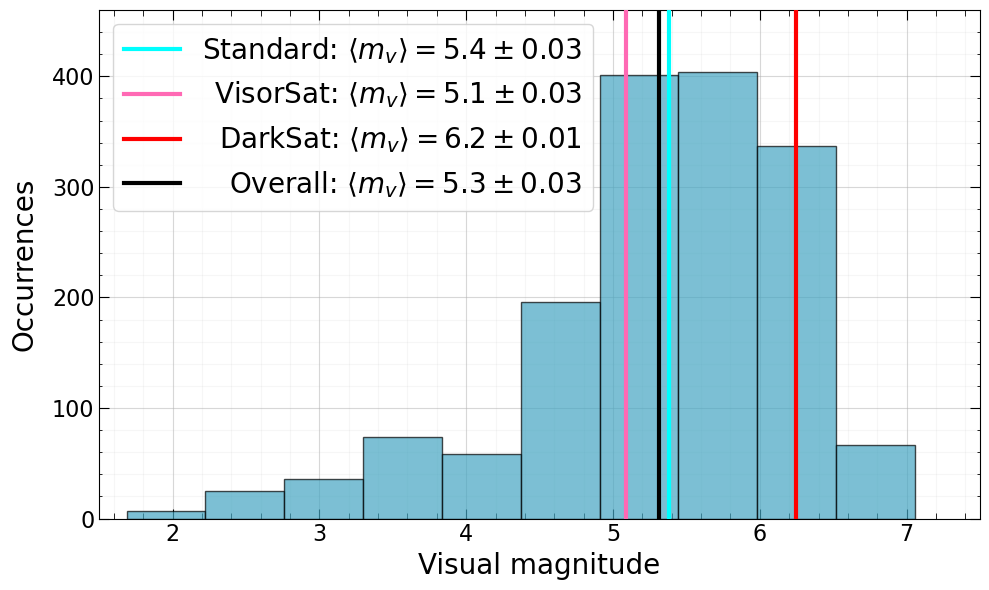

In [256]:
 def hist_averages():

    fig, ax = plt.subplots(1, 1, figsize=[10,6])
    
    standard = df[df.type=='standard'][['vmag', 'delta']]
    visors  = df[df.type=='visorsat'][['vmag', 'delta']]
    darksat = df[df.type=='darksat'][['vmag', 'delta']]
    
    print(np.mean(df.delta.values))
    print(np.mean(standard.delta))
    print(np.mean(visors.delta))
    print(np.mean(darksat.delta))
                        
    n_bins = 10
    ax.hist(df.vmag.values, n_bins, fc='#44a5c2', alpha=0.7, zorder=2, ec='k')
    ax.grid(alpha=0.5, which='both', zorder=1)
    ax.grid(which='minor', alpha=0.1, zorder=1)
    
    ax.axvline(np.mean(standard.vmag.values), label=r'Standard: $\langle m_v \rangle = {} \pm {}$'.format(
        round(np.mean(standard.vmag.values),1), round(np.std(standard.delta.values), 2)), c='cyan', lw=3, zorder=3)
    
    ax.axvline(np.mean(visors.vmag.values), label=r'VisorSat: $\langle m_v \rangle = {} \pm {}$'.format(
        round(np.mean(visors.vmag.values),1), round(np.std(visors.delta.values), 2)), c='hotpink', lw=3, zorder=3) 
    
    ax.axvline(np.mean(darksat.vmag.values), label=r'DarkSat: $\langle m_v \rangle = {} \pm {}$'.format(
        round(np.mean(darksat.vmag.values),1), round(np.std(darksat.delta.values), 2)), c='red', lw=3, zorder=3)
    
    ax.axvline(np.mean(df.vmag.values), label=r'Overall: $\langle m_v \rangle = {} \pm {}$'.format(
        round(np.mean(df.vmag.values),1), round(np.std(df.delta.values), 2)), c='k', lw=3, zorder=3) 

    ax.minorticks_on()
    ax.tick_params(axis='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='x', which='minor', length=4)
    ax.tick_params(axis='y', which='minor', direction='in', right=True)
    ax.yaxis.get_ticklocs(minor=True)
    ax.tick_params(axis='x', which='minor', top=True, direction='in')
    
    ax.set_ylabel('Occurrences', labelpad=10, fontsize=20)
    ax.set_xlabel('Visual magnitude', fontsize=20)
    leg = ax.legend(fontsize=20, facecolor='w')
#     leg = ax.legend(title=r'$(\pm 0.05)$', fontsize=18)
#     leg.get_title().set_fontsize(20)
    
    max_shift = max([t.get_window_extent().width for t in leg.get_texts()])
    for t in leg.get_texts():
        t.set_ha('left')  # ha is alias for horizontalalignment
        temp_shift = max_shift - t.get_window_extent().width
        t.set_position((temp_shift, 0))
        
    ax.set_xlim([1.5, 7.5])
    ax.set_ylim([0, 460])
    
    plt.tight_layout()
    plt.savefig(f'{savedir}avg_vmag_hist.png', bbox_inches='tight', dpi=300)
    plt.show()
    
hist_averages()

0.051751915470138
0.05152082592071
0.05258707560390282
0.04717774572835973
0.029903188658802978
0.030663293561847986
0.02713755948361379
0.009589894247905403


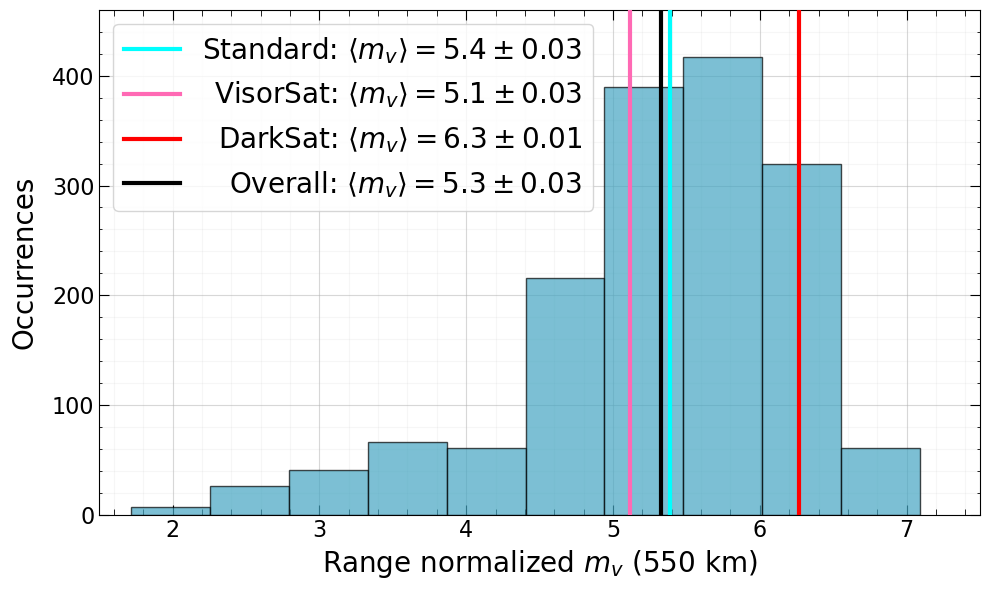

In [257]:
 def hist_averages_norm():

    fig, ax = plt.subplots(1, 1, figsize=[10,6])
    
    standard = df[df.type=='standard'][['vmag_norm', 'delta_norm']]
    visors  = df[df.type=='visorsat'][['vmag_norm', 'delta_norm']]
    darksat = df[df.type=='darksat'][['vmag_norm', 'delta_norm']]
    
    print(np.mean(df.delta_norm.values))
    print(np.mean(standard.delta_norm))
    print(np.mean(visors.delta_norm))
    print(np.mean(darksat.delta_norm))
    
    print(np.std(df.delta_norm.values))
    print(np.std(standard.delta_norm))
    print(np.std(visors.delta_norm))
    print(np.std(darksat.delta_norm))
                        
    n_bins = 10
    ax.hist(df.vmag_norm.values, n_bins, fc='#44a5c2', alpha=0.7, zorder=2, ec='k')
    ax.grid(alpha=0.5, which='both', zorder=1)
    ax.grid(which='minor', alpha=0.1, zorder=1)
    
    ax.axvline(np.mean(standard.vmag_norm.values), label=r'Standard: $\langle m_v \rangle = {} \pm {}$'.format(
        round(np.mean(standard.vmag_norm.values),1), round(np.std(standard.delta_norm.values), 2)), c='cyan', lw=3, zorder=3)
    
    ax.axvline(np.mean(visors.vmag_norm.values), label=r'VisorSat: $\langle m_v \rangle = {} \pm {}$'.format(
        round(np.mean(visors.vmag_norm.values),1), round(np.std(visors.delta_norm.values), 2)), c='hotpink', lw=3, zorder=3) 
    
    ax.axvline(np.mean(darksat.vmag_norm.values), label=r'DarkSat: $\langle m_v \rangle = {} \pm {}$'.format(
        round(np.mean(darksat.vmag_norm.values),1), round(np.std(darksat.delta_norm.values), 2)), c='red', lw=3, zorder=3)
    
    ax.axvline(np.mean(df.vmag_norm.values), label=r'Overall: $\langle m_v \rangle = {} \pm {}$'.format(
        round(np.mean(df.vmag_norm.values),1), round(np.std(df.delta_norm.values), 2)), c='k', lw=3, zorder=3) 

    ax.minorticks_on()
    ax.tick_params(axis='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='x', which='minor', length=4)
    ax.tick_params(axis='y', which='minor', direction='in', right=True)
    ax.yaxis.get_ticklocs(minor=True)
    ax.tick_params(axis='x', which='minor', top=True, direction='in')
    
    ax.set_ylabel('Occurrences', labelpad=10, fontsize=20)
    ax.set_xlabel('Range normalized $m_v$ (550 km)', fontsize=20)
    leg = ax.legend(fontsize=20, facecolor='w')
    
    max_shift = max([t.get_window_extent().width for t in leg.get_texts()])
    for t in leg.get_texts():
        t.set_ha('left')  # ha is alias for horizontalalignment
        temp_shift = max_shift - t.get_window_extent().width
        t.set_position((temp_shift, 0))
        
    ax.set_xlim([1.5, 7.5])
    ax.set_ylim([0, 460])
        
    plt.tight_layout()
    plt.savefig(f'{savedir}avg_vmag_hist_norm.png', bbox_inches='tight', dpi=300)
    plt.show()
    
hist_averages_norm()

In [75]:
def unique_df(df):
    
    unique_satdict = {}
    for satnum in df.satnum.unique():

        unique_satdict[satnum] = {'satname':[], 'vmag_norm':[], 'delta_norm':[], 'type':[], 'version':[]}

        vmag = np.mean(df.loc[df['satnum'] == satnum].vmag)
        delta = np.mean(df.loc[df['satnum'] == satnum].delta)
        sattype = df.loc[df['satnum'] == satnum].type.unique()[0]
        version = df.loc[df['satnum'] == satnum].version.unique()[0]
        satname = df.loc[df['satnum'] == satnum].satname.unique()[0]

        unique_satdict[satnum]['vmag_norm'].append(vmag)
        unique_satdict[satnum]['delta_norm'].append(delta)
        unique_satdict[satnum]['type'].append(sattype)
        unique_satdict[satnum]['version'].append(version)
        unique_satdict[satnum]['satname'].append(satname)

    d = pd.DataFrame(
        [(satnum, satname, vmag, delta, sattype, version) for satnum, vals in unique_satdict.items() 
         for satname, vmag, delta, sattype, version in zip(
             vals['satname'], vals['vmag_norm'], vals['delta_norm'], vals['type'], vals['version']
         )], columns=['satnum', 'satname', 'vmag_norm', 'delta_norm', 'type', 'version']
            )
    
    return d

In [76]:
df_uniq = unique_df(df)
df_uniq.head()

,satnum,satname,vmag_norm,delta_norm,type,version
0,48397U,STARLINK-2590,6.068897,0.052908,visorsat,1.0
1,48669U,STARLINK-2707,3.019464,0.046525,visorsat,1.0
2,47739U,STARLINK-2150,5.896793,0.043457,visorsat,1.0
3,48399U,STARLINK-2587,5.927386,0.032258,visorsat,1.0
4,51775U,STARLINK-3620,5.255940,0.037623,standard,1.5


In [83]:
 def unique_hist_averages_normalized(df):

    fig, ax = plt.subplots(1, 1, figsize=[10,6])
                        
    ax.hist(df.vmag_norm.values, fc='C0', alpha=0.6, zorder=2)
    ax.grid(alpha=0.5, which='both', zorder=1)
    ax.grid(which='minor', alpha=0.1, zorder=1)
    
    standard_mean = np.mean(df[df['type'] == 'standard'].vmag_norm)
    visor_mean = np.mean(df[df['type'] == 'visorsat'].vmag_norm)
    dark_mean = np.mean(df[df['type'] == 'darksat'].vmag_norm)
    all_mean = np.mean(df.vmag_norm.values)
    
    print(np.mean(df[df['type'] == 'standard'].delta_norm))
    print(np.mean(df[df['type'] == 'visorsat'].delta_norm))
    print(np.mean(df[df['type'] == 'darksat'].delta_norm))
    print(np.mean(df.delta_norm.values))
    
    ax.axvline(standard_mean, label=r'Standard: m$_v$ = {}'.format(round(standard_mean, 1)), c='C1', lw=2, zorder=3) 
    ax.axvline(visor_mean, label=r'VisorSat: m$_v$ = {}'.format(round(visor_mean, 1)), c='C3', lw=2, zorder=3) 
    ax.axvline(dark_mean, label=r'DarkSat: m$_v$ = {}'.format(round(dark_mean, 1)), c='m', lw=2, zorder=3)
    ax.axvline(all_mean, label=r'Overall: m$_v$ = {}'.format(round(all_mean, 1)), c='k', lw=2, zorder=3)

    ax.minorticks_on()
    ax.tick_params(axis='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='x', which='minor', length=4)
    ax.tick_params(axis='y', which='minor', direction='in', right=True)
    ax.yaxis.get_ticklocs(minor=True)
    ax.tick_params(axis='x', which='minor', top=True, direction='in')
    
    ax.set_ylabel('Occurrences', labelpad=10, fontsize=20)
    ax.set_xlabel('Visual magnitude', fontsize=20)
    leg = ax.legend(title=r'Average values ($\pm 0.06$)', fontsize=18)
    leg.get_title().set_fontsize(20)
    
    max_shift = max([t.get_window_extent().width for t in leg.get_texts()])
    for t in leg.get_texts():
        t.set_ha('right')  # ha is alias for horizontalalignment
        temp_shift = max_shift - t.get_window_extent().width
        t.set_position((temp_shift, 0))
        
    plt.tight_layout()
    plt.savefig(f'{savedir}uniq_avg_vmag_norm_hist.png', bbox_inches='tight', dpi=300)
    plt.show()

0.06161863064467948
0.056944622195232254
0.04711179861100349
0.06002246408983762


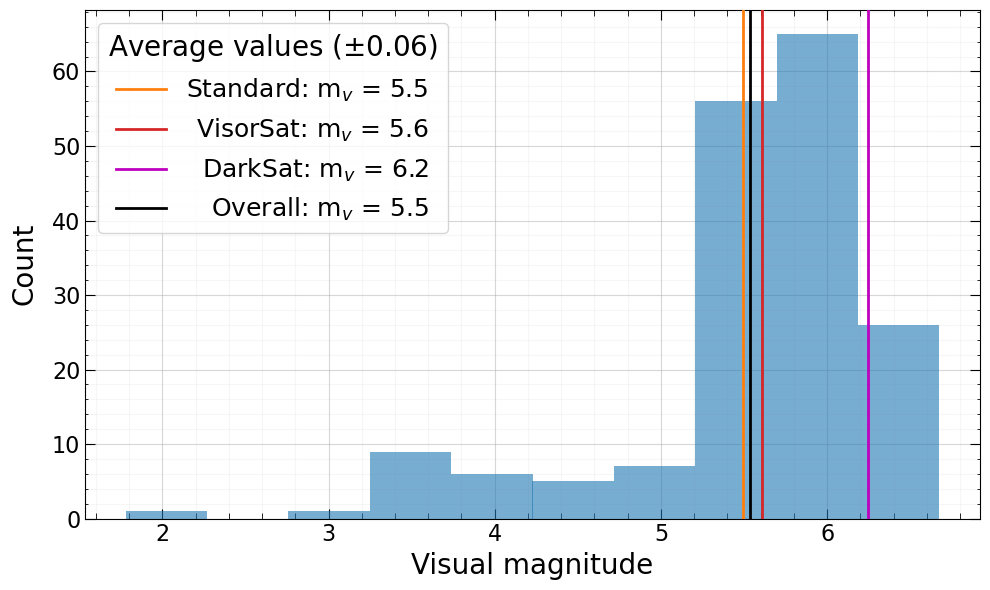

In [84]:
unique_hist_averages_normalized(df_uniq)

In [85]:
 def hist_mag_alt():
        
    import matplotlib.dates as mdates

    fig, ax = plt.subplots(1, 1, figsize=[10,6])
    
    # SORTING JDs --> ensure vmags are sorted accordingly!
    subset = df[['JD0', 'vmag']]
    subset_sorted = subset.sort_values('JD0')
    jd = subset_sorted['JD0'].values
    vm = subset_sorted['vmag'].values
    
    times = Time(jd, format='jd') 
    ax.hist(times.datetime, bins=20, weights=vm, alpha=0.5)

    # Format the x-axis to display dates
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H-%M'))

    # Altitudes
    mag_twin = ax.twinx().twiny()
    mag_twin.set_yticklabels([])
    mag_twin.set_yticks([])
    mag_twin.set_xticks([])
    elapsed_time = ((times - times[0]) * 86400).value
    
    t4, t6, t8 = [], [], []
    v4, v6, v8 = [], [], []
    for i, vm in enumerate(vm):
        if vm < 4:
            t4.append(elapsed_time[i])
            v4.append(vm)
        if vm >= 4 and vm < 6:
            t6.append(elapsed_time[i])
            v6.append(vm)
        if vm >= 6 and vm < 8:
            t8.append(elapsed_time[i])
            v8.append(vm)
            
    mag_twin.scatter(t4, v4, c='k', alpha=0.5, s=5, label=r'$m_v < 4$')
    mag_twin.scatter(t6, v6, c='r', alpha=0.5, s=5, label=r'$4 \geq m_v < 6$')
    mag_twin.scatter(t8, v8, c='g', alpha=0.5, s=5, label=r'$6 \geq m_v < 8$')
    mag_twin.legend()
    
    twin = ax.twinx().twiny()
    twin.set_xticklabels([])
    twin.set_xticks([])
    t0 = Time(jd[0], format='jd')
    t1 = Time(jd[-1], format='jd')
    time_range = np.arange(t0.jd, t1.jd, 600 / (24 * 60 * 60))
    times = Time(time_range, format='jd')
    elapsed_time = ((times - times[0]) * 86400).value

    ts = load.timescale()
    site = get_siteinfo()
    mascara = wgs84.latlon(latitude_degrees=site[0][1], longitude_degrees=site[0][2], elevation_m=site[0][3])
    observer = mascara + eph['earth']

    altitudes = []
    all_times = []
    starlink_tles = get_tles()    
    for satname in df.satname.unique():

        for i, tle in enumerate(starlink_tles):
            if satname in tle[0]:
                sat = EarthSatellite(tle[1], tle[2], tle[0], ts)
                diff = sat - mascara

                alts = []
                hist_times = []
                for t in times:
                    topocentric = diff.at(ts.from_astropy(t))
                    alt, az, dist = topocentric.altaz()
                    phase_angle = np.degrees(np.arctan2(alt.radians, az.radians))
                    alts.append(alt.degrees)
                    hist_times.append(t.datetime)
                    
                #twin.scatter(time_range, alts, c='m', s=10, alpha=0.5)
                altitudes.extend(alts)
                all_times.extend(hist_times)
            
                 
    twin.hist(all_times, bins=20, weights=altitudes, alpha=0.3)
    twin.invert_yaxis()

    # Format the x-axis to display dates
#     twin.xaxis.set_major_locator(mdates.AutoDateLocator())
#     twin.xaxis.set_major_formatter(mdates.DateFormatter('%H-%M'))
        
    plt.tight_layout()
    plt.show()

In [87]:
 def hist_mag_alt():
        
    import matplotlib.dates as mdates

    fig, ax = plt.subplots(1, 1, figsize=[10,6])
    
    # SORTING JDs --> ensure vmags are sorted accordingly!
    subset = df[['JD0', 'vmag']]
    subset_sorted = subset.sort_values('JD0')
    jd = subset_sorted['JD0'].values
    vm = subset_sorted['vmag'].values
    
    times = Time(jd, format='jd') 
    ax.hist(times.datetime, bins=20, weights=vm, alpha=0.5)

    # Format the x-axis to display dates
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H-%M'))

    # Altitudes
    mag_twin = ax.twinx().twiny()
    mag_twin.set_yticklabels([])
    mag_twin.set_yticks([])
    mag_twin.set_xticks([])
    elapsed_time = ((times - times[0]) * 86400).value
    
    t4, t6, t8 = [], [], []
    v4, v6, v8 = [], [], []
    for i, vm in enumerate(vm):
        if vm < 4:
            t4.append(elapsed_time[i])
            v4.append(vm)
        if vm >= 4 and vm < 6:
            t6.append(elapsed_time[i])
            v6.append(vm)
        if vm >= 6 and vm < 8:
            t8.append(elapsed_time[i])
            v8.append(vm)
            
    mag_twin.scatter(t4, v4, c='k', alpha=0.5, s=5, label=r'$m_v < 4$')
    mag_twin.scatter(t6, v6, c='r', alpha=0.5, s=5, label=r'$4 \geq m_v < 6$')
    mag_twin.scatter(t8, v8, c='g', alpha=0.5, s=5, label=r'$6 \geq m_v < 8$')
    mag_twin.legend()
    
    twin = ax.twinx().twiny()
    twin.set_xticklabels([])
#     twin.set_yticks([])
    twin.set_xticks([])
    t0 = Time(jd[0], format='jd')
    t1 = Time(jd[-1], format='jd')
    time_range = np.arange(t0.jd, t1.jd, 600 / (24 * 60 * 60))
    times = Time(time_range, format='jd')
    elapsed_time = ((times - times[0]) * 86400).value

    ts = load.timescale()
    site = get_siteinfo()
    mascara = wgs84.latlon(latitude_degrees=site[0][1], longitude_degrees=site[0][2], elevation_m=site[0][3])
    observer = mascara + eph['earth']

    altitudes = []
    starlink_tles = get_tles()  
    
    for t in times:
        
        for satname in df.satname.unique():

            for i, tle in enumerate(starlink_tles):
                if satname in tle[0]:
                    sat = EarthSatellite(tle[1], tle[2], tle[0], ts)
                    diff = sat - mascara

                    alts = []
                    topocentric = diff.at(ts.from_astropy(t))
                    alt, az, dist = topocentric.altaz()
                    alts.append(alt.degrees)
                    
        altitudes.append(alts)
#         twin.scatter(time_range, alts, c='m', s=10, alpha=0.5)
#         x_min, x_max = min(time_range), max(time_range)
#         y_min, y_max = min(alts), max(alts)
#         plt.fill_between([x_min, x_max], y_min, y_max, alpha=0.2)

    min_alts = [min(lst) for lst in altitudes]
    max_alts = [max(lst) for lst in altitudes]
    twin.scatter(time_range, min_alts, c='k')
#     twin.scatter(time_range, max_alts, c='orange')
    
        
    plt.tight_layout()
    plt.show()
    
    
# hist_mag_alt()

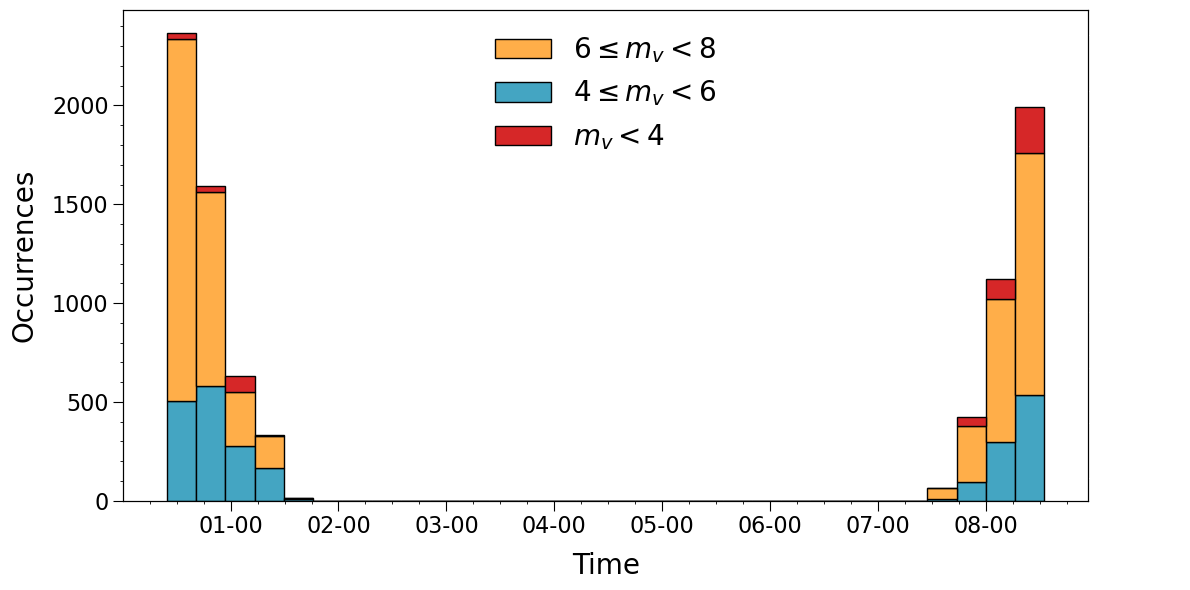

In [88]:
def hist_mag(savefig=False):

    import matplotlib.dates as mdates
    fig, ax = plt.subplots(1, 1, figsize=[12,6])

    # SORTING JDs --> ensure vmags are sorted accordingly!
    subset = df[['JD0', 'vmag']]
    subset_sorted = subset.sort_values('JD0')
    jd = subset_sorted['JD0'].values
    vmags = subset_sorted['vmag'].values

    times = Time(jd, format='jd') 
    ax.hist(times.datetime, bins=30, weights=vmags, fc='None')

    # Format the x-axis to display dates
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H-%M'))

    t4, t6, t8 = [], [], []
    v4, v6, v8 = [], [], []
    for i, vm in enumerate(vmags):
        if vm < 4:
            t4.append(jd[i])
            v4.append(vm)
        if vm >= 4 and vm < 6:
            t6.append(jd[i])
            v6.append(vm)
        if vm >= 6 and vm < 8:
            t8.append(jd[i])
            v8.append(vm)

    t8 = Time(t8, format='jd').datetime
    t6 = Time(t6, format='jd').datetime
    t4 = Time(t4, format='jd').datetime

    cols = ['#44a5c2', '#ffae49', 'C3']
    labs = [r'$4 \leq m_v < 6$', r'$6 \leq m_v < 8$', r'$m_v < 4$']
    ax.hist([t8,t6,t4], bins=30, weights=[v8,v6,v4], color=cols, label=labs, ec='k', stacked=True)

    handles, labels = ax.get_legend_handles_labels()
    order = [1,0,2]
    ax.legend(
        [handles[idx] for idx in order], [labels[idx] for idx in order], 
        loc='upper center', fontsize=20, frameon=False) 

    ax.minorticks_on()
    ax.tick_params(axis='y', which='both', direction='out', right=False)
    ax.tick_params(axis='x', which='both', direction='out', top=False)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='both', which='minor', length=2)
    ax.set_ylabel('Occurrences', labelpad=10, fontsize=20)
    ax.set_xlabel('Time', fontsize=20, labelpad=10)
    
    
    # Altitudes
    twin = ax.twinx()
    t0 = Time(jd[0], format='jd')
    t1 = Time(jd[-1], format='jd')
    time_range = np.arange(t0.jd, t1.jd, 600 / (24 * 60 * 60))
    times = Time(time_range, format='jd')

    ts = load.timescale()
    site = get_siteinfo()
    mascara = wgs84.latlon(latitude_degrees=site[0][1], longitude_degrees=site[0][2], elevation_m=site[0][3])
    observer = mascara + eph['earth']

    starlink_tles = get_tles()    
    for satname in df.satname.unique():

        for i, tle in enumerate(starlink_tles):
            if satname in tle[0]:
                sat = EarthSatellite(tle[1], tle[2], tle[0], ts)
                diff = sat - mascara

                alts = []
                obs_times = []
                for t in times:
                    obs_time = ts.from_astropy(t)
                    topocentric = diff.at(obs_time)
                    alt, az, dist = topocentric.altaz()
                    if alt.degrees > 0:
                        alts.append(alt.degrees)
                        obs_times.append(t.datetime)

        twin.scatter(obs_times, alts, fc='None', ec='None')


    twin.tick_params(axis='y', which='major', length=7, labelsize=16)
    twin.set_ylabel('Altitude (deg)', fontsize=20, labelpad=15)
    twin.yaxis.label.set_color('w')
    twin.tick_params(axis='y', colors='w')

    plt.tight_layout()
    if savefig:
        plt.savefig(f'{savedir}hist_mag.png', dpi=300, bbox_inches='tight')
    plt.show()
    

hist_mag(savefig=False)

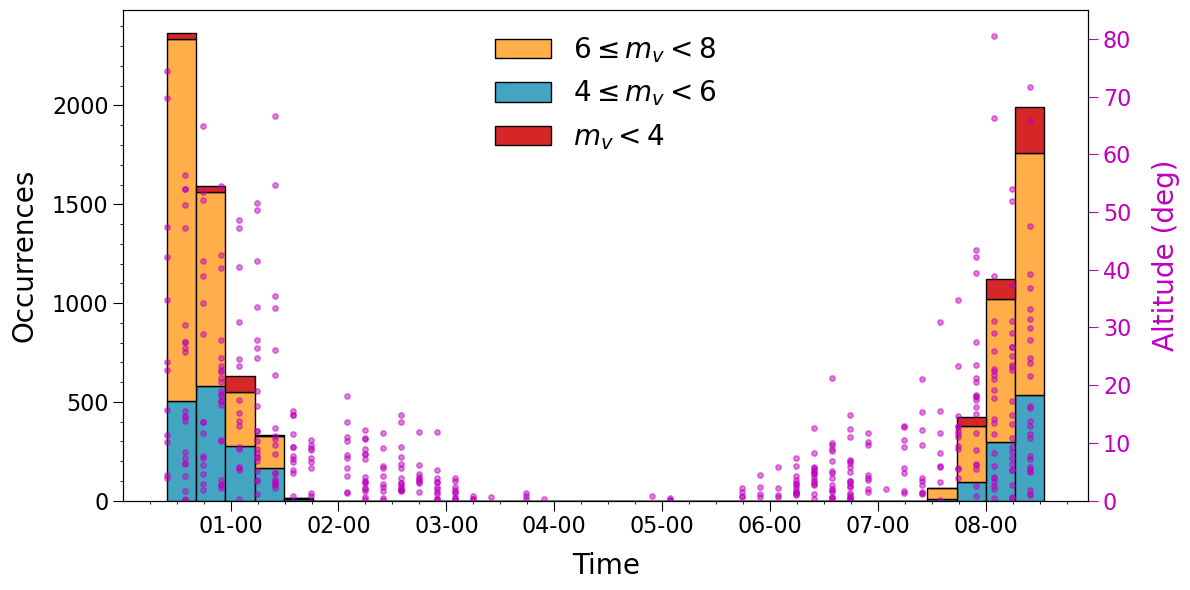

In [109]:
def hist_mag_alt(savefig=False):

    import matplotlib.dates as mdates
    fig, ax = plt.subplots(1, 1, figsize=[12,6])

    # SORTING JDs --> ensure vmags are sorted accordingly!
    subset = df[['JD0', 'vmag']]
    subset_sorted = subset.sort_values('JD0')
    jd = subset_sorted['JD0'].values
    vmags = subset_sorted['vmag'].values

    times = Time(jd, format='jd') 
    ax.hist(times.datetime, bins=30, weights=vmags, fc='None')

    # Format the x-axis to display dates
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H-%M'))

    t4, t6, t8 = [], [], []
    v4, v6, v8 = [], [], []
    for i, vm in enumerate(vmags):
        if vm < 4:
            t4.append(jd[i])
            v4.append(vm)
        if vm >= 4 and vm < 6:
            t6.append(jd[i])
            v6.append(vm)
        if vm >= 6 and vm < 8:
            t8.append(jd[i])
            v8.append(vm)

    t8 = Time(t8, format='jd').datetime
    t6 = Time(t6, format='jd').datetime
    t4 = Time(t4, format='jd').datetime

    cols = ['#44a5c2', '#ffae49', 'C3']
    labs = [r'$4 \leq m_v < 6$', r'$6 \leq m_v < 8$', r'$m_v < 4$']
    ax.hist([t8,t6,t4], bins=30, weights=[v8,v6,v4], color=cols, label=labs, ec='k', stacked=True)

    handles, labels = ax.get_legend_handles_labels()
    order = [1,0,2]
    ax.legend(
        [handles[idx] for idx in order], [labels[idx] for idx in order], 
        loc='upper center', fontsize=20, frameon=False) 

    ax.minorticks_on()
    ax.tick_params(axis='y', which='both', direction='out', right=False)
    ax.tick_params(axis='x', which='both', direction='out', top=False)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='both', which='minor', length=2)
    ax.set_ylabel('Occurrences', labelpad=10, fontsize=20)
    ax.set_xlabel('Time', fontsize=20, labelpad=10)


    # Altitudes
    twin = ax.twinx()
    t0 = Time(jd[0], format='jd')
    t1 = Time(jd[-1], format='jd')
    time_range = np.arange(t0.jd, t1.jd, 600 / (24 * 60 * 60))
    times = Time(time_range, format='jd')

    ts = load.timescale()
    site = get_siteinfo()
    mascara = wgs84.latlon(latitude_degrees=site[0][1], longitude_degrees=site[0][2], elevation_m=site[0][3])
    observer = mascara + eph['earth']

    starlink_tles = get_tles()    
    for satname in df.satname.unique():

        for i, tle in enumerate(starlink_tles):
            if satname in tle[0]:
                sat = EarthSatellite(tle[1], tle[2], tle[0], ts)
                diff = sat - mascara

                alts = []
                obs_times = []
                for t in times:
                    obs_time = ts.from_astropy(t)
                    topocentric = diff.at(obs_time)
                    alt, az, dist = topocentric.altaz()
                    if alt.degrees > 0:
                        alts.append(alt.degrees)
                        obs_times.append(t.datetime)

        twin.scatter(obs_times, alts, c='m', s=15, alpha=0.5)


    twin.tick_params(axis='y', which='major', length=7, labelsize=16)
    twin.set_ylabel('Altitude (deg)', fontsize=20, labelpad=15)
    twin.yaxis.label.set_color('m')
    twin.tick_params(axis='y', colors='m')
    twin.set_ylim([0,85])
    plt.tight_layout()
    if savefig:
        plt.savefig(f'{savedir}hist_mag_alt.png', dpi=300, bbox_inches='tight')
    plt.show()
    

hist_mag_alt(savefig=True)

## Phase angle analysis

A powerful method for quantifying and predicting magnitudes is Phase Function (PF) analysis. The phase angle provides information about illumination based on the geometry of the satellite, the Sun and the observer (or sensor). An object’s phase angle is the arc length between the Sun and the observer as measured at the object. When the phase angle is zero the Sun and observer are aligned as seen from the object, and when it is 180o they are in opposite directions. There is a standard PF which corresponds to the fraction of a spherical object illuminated as a function of phase angle. This standard function is brightest at small phase angles when the side of the object facing the observer is fully lit by the Sun and, conversely, it is faintest when the object is back-lit. An empirical PF is derived by least-squares fitting of the observed magnitudes at a standard distance to their phase angles. A quadratic polynomial equation is adequate for fitting Starlink satellite magnitudes.

In [110]:
df.columns

Index(['satnum', 'satname', 'vmag', 'delta', 'JD0', 'JD1', 'camid', 'type',
       'version', 'launch', 'inc', 'phase_angle', 'height', 'alt', 'az', 'ra',
       'dec', 'range', 'vmag_norm', 'delta_norm'],
      dtype='object')

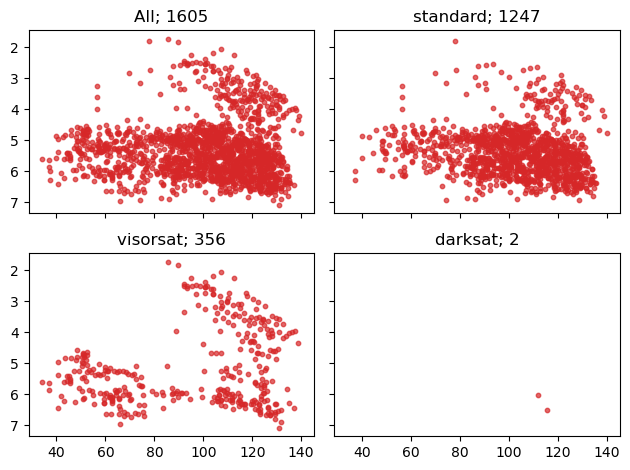

In [244]:
fig, axs = plt.subplots(2, 2, sharey=True, sharex=True)

axs[0,0].scatter(df.phase_angle, df.vmag_norm, s=10, c='C3', alpha=0.7)
axs[0,0].set_title(f'All; {len(df)}')
axs[0,0].invert_yaxis()

for sattype, ax in zip(['standard', 'visorsat', 'darksat'], axs.ravel()[1:]):
    ax.scatter(df[df['type']==sattype].phase_angle, df[df['type']==sattype].vmag_norm, s=10, c='C3', alpha=0.7)
    ax.set_title(f"{sattype}; {len(df[df['type']==sattype])}")
    

    
plt.tight_layout()    
plt.show()

### Timerange spanned: 2022-10-24 00:23:19   -   2022-10-24 09:02:45

In [128]:
import datetime as dt
from pytz import timezone
from skyfield import almanac
from skyfield.api import N, W, wgs84, load

# local midnight
zone = timezone('Chile/Continental')
t0 = zone.localize(dt.datetime(2022, 10, 23))
midnight = t0.replace(hour=0, minute=0, second=0, microsecond=0)
next_midnight = midnight + dt.timedelta(days=2)

ts = load.timescale()
t0 = ts.from_datetime(midnight)
t1 = ts.from_datetime(next_midnight)
eph = load('de421.bsp')

site = get_siteinfo()
mascara = wgs84.latlon(latitude_degrees=site[0][1], longitude_degrees=site[0][2], elevation_m=site[0][3])

f = almanac.dark_twilight_day(eph, mascara)
times, events = almanac.find_discrete(t0, t1, f)

previous_e = f(t0).item()
for t, e in zip(times, events):
    tstr = str(t.astimezone(zone))[:16]
    if previous_e < e:
        print(tstr, ' ', almanac.TWILIGHTS[e], 'starts')
    else:
        print(tstr, ' ', almanac.TWILIGHTS[previous_e], 'ends')
    previous_e = e

2022-10-23 05:33   Astronomical twilight starts
2022-10-23 06:03   Nautical twilight starts
2022-10-23 06:32   Civil twilight starts
2022-10-23 06:57   Day starts
2022-10-23 19:57   Day ends
2022-10-23 20:22   Civil twilight ends
2022-10-23 20:51   Nautical twilight ends
2022-10-23 21:21   Astronomical twilight ends
2022-10-24 05:32   Astronomical twilight starts
2022-10-24 06:02   Nautical twilight starts
2022-10-24 06:31   Civil twilight starts
2022-10-24 06:56   Day starts
2022-10-24 19:58   Day ends
2022-10-24 20:23   Civil twilight ends
2022-10-24 20:52   Nautical twilight ends
2022-10-24 21:22   Astronomical twilight ends


In the context of celestial observations, altitude and elevation are often used interchangeably, referring to the vertical angle between an object (such as the Sun, a star, or a planet) and an observer's horizon.

Altitude or elevation generally represents the object's height above the observer's horizon. It is measured in degrees and can range from 0° at the horizon to 90° at the zenith (directly overhead).

So, in the context of determining the Sun's position, altitude and elevation refer to the same concept—the angle between the Sun and the observer's horizon.

In [201]:
# ts = load.timescale()
# t0 = ts.from_datetime(midnight)
# t1 = ts.from_datetime(next_midnight)
# eph = load('de421.bsp')
# sun = eph['Sun']
# earth = eph['Earth']

# site = get_siteinfo()
# # mascara = wgs84.latlon(latitude_degrees=site[0][1], longitude_degrees=site[0][2], elevation_m=site[0][3])
# mascara = Topos(latitude_degrees=site[0][1], longitude_degrees=site[0][2], elevation_m=site[0][3])
# observer = mascara + earth
 
# sun_elev = []
# sun_az = []
# for t in sorted(df['JD0']):
#     obs_time = Time(t, format='jd')
#     obs_time = ts.from_astropy(obs_time)
#     sun_pos = observer.at(obs_time).observe(sun).apparent()
#     alt, az, dist = sun_pos.altaz()
#     sun_elev.append(alt.degrees)
#     sun_az.append(az.degrees)

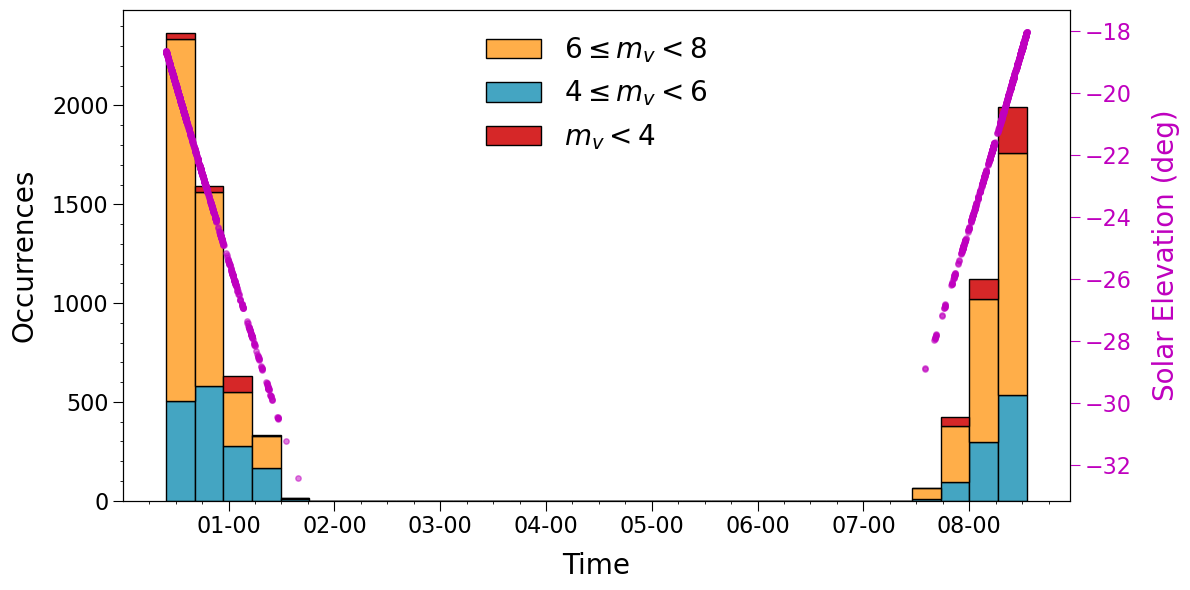

In [132]:
def hist_mag_elev(savefig=False):

    import matplotlib.dates as mdates
    fig, ax = plt.subplots(1, 1, figsize=[12,6])

    # SORTING JDs --> ensure vmags are sorted accordingly!
    subset = df[['JD0', 'vmag']]
    subset_sorted = subset.sort_values('JD0')
    jd = subset_sorted['JD0'].values
    vmags = subset_sorted['vmag'].values

    times = Time(jd, format='jd') 
    ax.hist(times.datetime, bins=30, weights=vmags, fc='None')

    # Format the x-axis to display dates
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H-%M'))

    t4, t6, t8 = [], [], []
    v4, v6, v8 = [], [], []
    for i, vm in enumerate(vmags):
        if vm < 4:
            t4.append(jd[i])
            v4.append(vm)
        if vm >= 4 and vm < 6:
            t6.append(jd[i])
            v6.append(vm)
        if vm >= 6 and vm < 8:
            t8.append(jd[i])
            v8.append(vm)

    t8 = Time(t8, format='jd').datetime
    t6 = Time(t6, format='jd').datetime
    t4 = Time(t4, format='jd').datetime

    cols = ['#44a5c2', '#ffae49', 'C3']
    labs = [r'$4 \leq m_v < 6$', r'$6 \leq m_v < 8$', r'$m_v < 4$']
    ax.hist([t8,t6,t4], bins=30, weights=[v8,v6,v4], color=cols, label=labs, ec='k', stacked=True)

    handles, labels = ax.get_legend_handles_labels()
    order = [1,0,2]
    ax.legend(
        [handles[idx] for idx in order], [labels[idx] for idx in order], 
        loc='upper center', fontsize=20, frameon=False) 

    ax.minorticks_on()
    ax.tick_params(axis='y', which='both', direction='out', right=False)
    ax.tick_params(axis='x', which='both', direction='out', top=False)
    ax.tick_params(axis='both', which='major', length=7, labelsize=16)
    ax.tick_params(axis='both', which='minor', length=2)
    ax.set_ylabel('Occurrences', labelpad=10, fontsize=20)
    ax.set_xlabel('Time', fontsize=20, labelpad=10)


    jd = sorted(df['JD0'])
    times = Time(jd, format='jd') 
    
    twin = ax.twinx()
    twin.scatter(times.datetime, sun_alt, c='m', s=15, alpha=0.5)
    twin.tick_params(axis='y', which='major', length=7, labelsize=16)
    twin.set_ylabel('Solar Elevation (deg)', fontsize=20, labelpad=15)
    twin.yaxis.label.set_color('m')
    twin.tick_params(axis='y', colors='m')
    plt.tight_layout()
    if savefig:
        plt.savefig(f'{savedir}hist_mag_elev.png', dpi=300, bbox_inches='tight')
    plt.show()
    

hist_mag_elev(savefig=False)

 |  phase_angle(self, sun)
 |      Return this position’s phase angle: the angle Sun-target-observer.
 |      
 |      Given a Sun object (which you can build by loading an ephemeris
 |      and looking up ``eph['Sun']``), return the `Angle` from the
 |      body's point of view between light arriving from the Sun and the
 |      light departing toward the observer.  This angle is 0° if the
 |      observer is in the same direction as the Sun and sees the body
 |      as fully illuminated, and 180° if the observer is behind the
 |      body and sees only its dark side.

In [ ]:
ts = load.timescale()
t0 = ts.from_datetime(midnight)
t1 = ts.from_datetime(next_midnight)
eph = load('de421.bsp')
sun = eph['Sun']
earth = eph['Earth']

site = get_siteinfo()
# mascara = wgs84.latlon(latitude_degrees=site[0][1], longitude_degrees=site[0][2], elevation_m=site[0][3])
mascara = Topos(latitude_degrees=site[0][1], longitude_degrees=site[0][2], elevation_m=site[0][3])
observer = mascara + earth
 
sun_elev = []
sun_az = []
for t in sorted(df['JD0']):
    obs_time = Time(t, format='jd')
    obs_time = ts.from_astropy(obs_time)
    sun_pos = observer.at(obs_time).observe(sun).apparent()
    alt, az, dist = sun_pos.altaz()
    sun_elev.append(alt.degrees)
    sun_az.append(az.degrees)

1605
NOT SEEING ZWICKY TREND :(


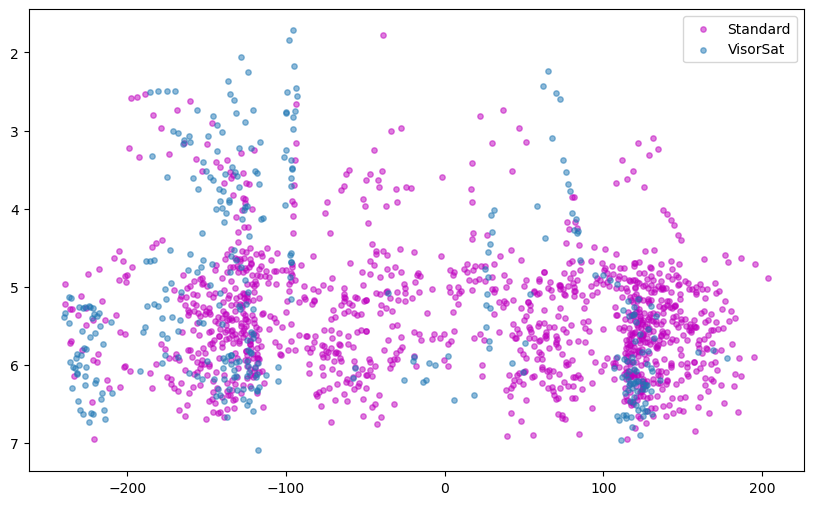

In [242]:
fig, ax = plt.subplots(1, 1, figsize=[10,6])

sorted_df = df.sort_values('JD0')

standard = sorted_df[sorted_df['type']=='standard']
visorsat = sorted_df[sorted_df['type']=='visorsat']

sun_az_standard = [sun_az[i] for i in standard.index.values] 
sun_az_visorsat = [sun_az[i] for i in visorsat.index.values] 

az_diff_standard = standard.az.values - sun_az_standard
az_diff_visorsat = visorsat.az.values - sun_az_visorsat

# az_diff = sorted_df.az.values - sun_az 
# ax.scatter(az_diff, sorted_df.vmag_norm, c='m', s=15, alpha=0.5)
# ax.errorbar(az_diff, df.vmag_norm, yerr=df.delta_norm, fmt='o', markersize=2)

ax.scatter(az_diff_standard, standard.vmag_norm, c='m', s=15, alpha=0.5, label='Standard')
ax.scatter(az_diff_visorsat, visorsat.vmag_norm, c='C0', s=15, alpha=0.5, label='VisorSat')

ax.legend()

ax.invert_yaxis()

print(len(az_diff_standard) + len(az_diff_visorsat) + 2)

print('NOT SEEING ZWICKY TREND :(')

plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, sharey=True, sharex=True)

axs[0,0].scatter(df.phase_angle, df.vmag_norm, s=10, c='C3', alpha=0.7)
axs[0,0].set_title(f'All; {len(df)}')
axs[0,0].invert_yaxis()

for sattype, ax in zip(['standard', 'visorsat', 'darksat'], axs.ravel()[1:]):
    ax.scatter(df[df['type']==sattype].phase_angle, df[df['type']==sattype].vmag_norm, s=10, c='C3', alpha=0.7)
    ax.set_title(f"{sattype}; {len(df[df['type']==sattype])}")
    

    
plt.tight_layout()    
plt.show()

In [262]:
eph = load('de421.bsp')
sun = eph['sun']
earth = eph['earth']

ts = load.timescale()
site = get_siteinfo()
mascara = wgs84.latlon(latitude_degrees=site[0][1], longitude_degrees=site[0][2], elevation_m=site[0][3])
observer = mascara + earth

test_jd = df[df['satname']==sat.name].JD0.values[0]
t = Time(test_jd, format='jd')
obs_time = ts.from_astropy(t)


obs_sat = earth + sat
topo_sat_obs = obs_sat.at(obs_time).observe(observer).apparent()
topo_sat_sun = obs_sat.at(obs_time).observe(sun).apparent() 
phase_angle = topo_sat_obs.separation_from(topo_sat_sun).degrees

print(phase_angle)



115.80309156442272


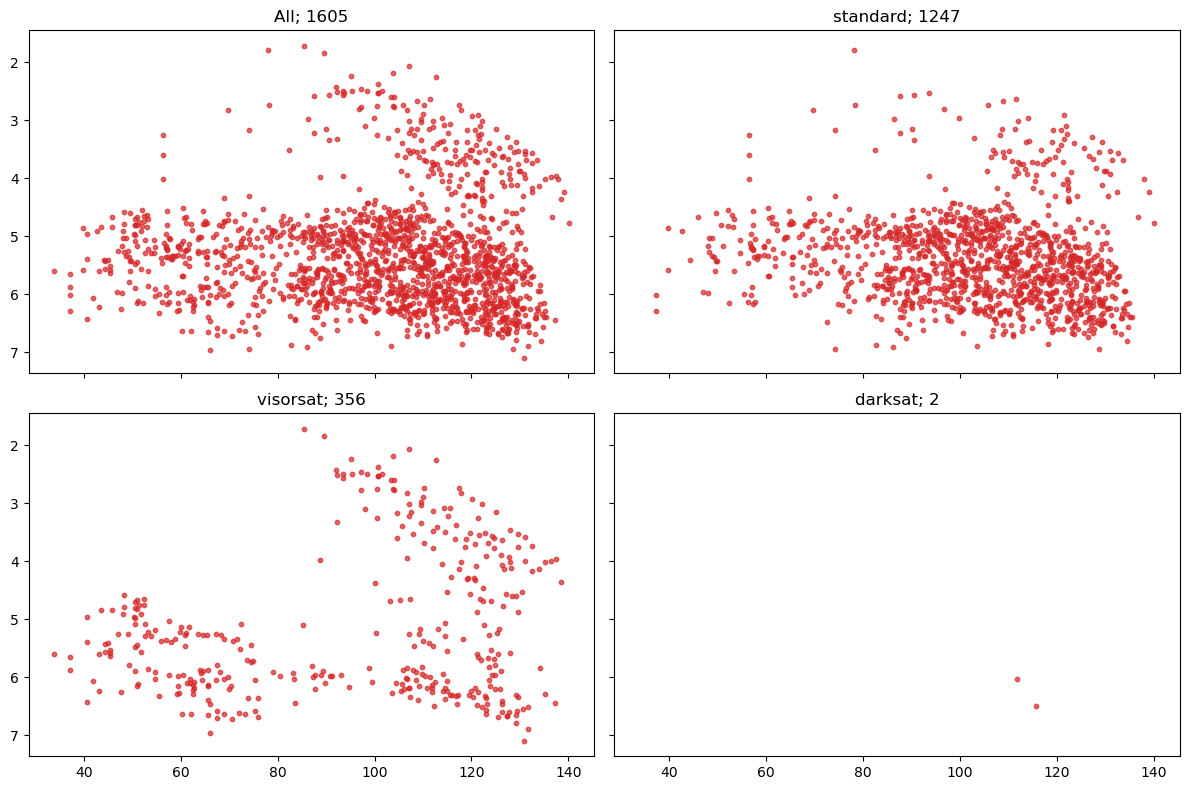

In [263]:
fig, axs = plt.subplots(2, 2, figsize=[12,8], sharey=True, sharex=True)

axs[0,0].scatter(df.phase_angle, df.vmag_norm, s=10, c='C3', alpha=0.7)
axs[0,0].set_title(f'All; {len(df)}')
axs[0,0].invert_yaxis()

for sattype, ax in zip(['standard', 'visorsat', 'darksat'], axs.ravel()[1:]):
    ax.scatter(df[df['type']==sattype].phase_angle, df[df['type']==sattype].vmag_norm, s=10, c='C3', alpha=0.7)
    ax.set_title(f"{sattype}; {len(df[df['type']==sattype])}")

    
plt.tight_layout()    
plt.show()

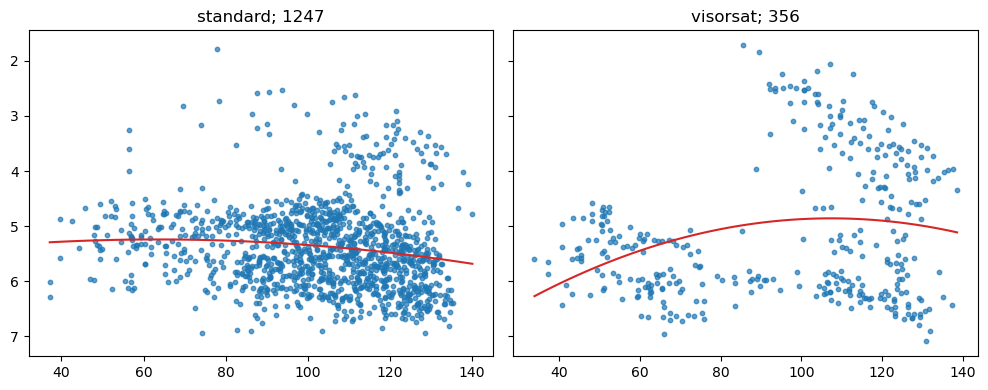

In [271]:
fig, axs = plt.subplots(1, 2, figsize=[10,4], sharey=True)

for sattype, ax in zip(['standard', 'visorsat'], axs.flat):

    x = df[df['type']==sattype].phase_angle
    y = df[df['type']==sattype].vmag_norm
    ax.scatter(x, y, s=10, c='C0', alpha=0.7)
    ax.set_title(f"{sattype}; {len(df[df['type']==sattype])}")

    coeffs = np.polyfit(x, y, 2)
    quad_eqn = np.poly1d(coeffs)
    x_vals = np.linspace(min(x), max(x), 100)
    y_vals = quad_eqn(x_vals)

    ax.plot(x_vals, y_vals, color='C3')
    
ax.invert_yaxis()    
plt.tight_layout()    
plt.show()



# Clearly, my results are semi-fucked. MOVE ON, FOCUS ON TALK!

## Corrected sun and sat azimuth debauchery !

In [47]:
ts = load.timescale()
eph = load('de421.bsp')
sun = eph['Sun']
earth = eph['Earth']
starlink_tles = get_tles()

site = get_siteinfo()
mascara = wgs84.latlon(latitude_degrees=site[0][1], longitude_degrees=site[0][2], elevation_m=site[0][3])
observer = mascara + earth

sun_az = []
sun_alt = []
phase = []

sat_az = []
sat_alt = []
sat_mag = []
sat_type = []
sat_delta = []

sorted_df = df.sort_values('JD0')
for index, row in sorted_df.iterrows():
    t = row['JD0']
    obs_time = ts.ut1_jd(t)
    
    # Sun position
    astro = observer.at(obs_time).observe(sun)
    app = astro.apparent()
    alt, az, dist = app.altaz()
    sun_az.append(az.degrees)
    sun_alt.append(alt.degrees)
    
    # Satellite position
    satname = row.satname
    for tle in starlink_tles:
        if satname in tle[0]:
            sat = EarthSatellite(tle[1], tle[2], tle[0], ts) 
            diff = sat - mascara
            topocentric = diff.at(obs_time)
            alt, az, dist = topocentric.altaz()
            sat_az.append(az.degrees)
            sat_alt.append(alt.degrees)
            sat_mag.append(row['vmag_norm'])
            sat_type.append(row['type'])
            sat_delta.append(row['delta_norm'])
            
            # phase_angle(): given an illuminator (usually the Sun) as their argument, compute 
            # the angle Sun-target-observer. Returns the Angle from the body’s point of view between 
            # light arriving from the Sun and the light departing toward the observer. This angle is 0° 
            # if the observer is in the same direction as the Sun and sees the body as fully illuminated, 
            # and 180° if the observer is behind the body and sees only its dark side
            
            sat_pov = earth + sat
            phase_angle = sat_pov.at(obs_time).observe(observer).phase_angle(sun)
            phase.append(phase_angle.degrees)

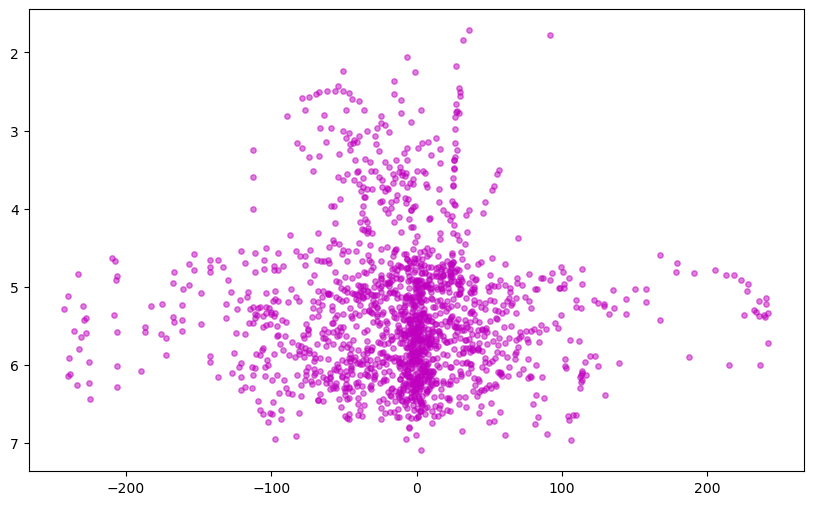

In [170]:
fig, ax = plt.subplots(1, 1, figsize=[10,6])

az_diff = [x - y for (x, y) in zip(sat_az, sun_az)] 
ax.scatter(az_diff, sat_mag, c='m', s=15, alpha=0.5)

ax.invert_yaxis()

plt.show()

1605


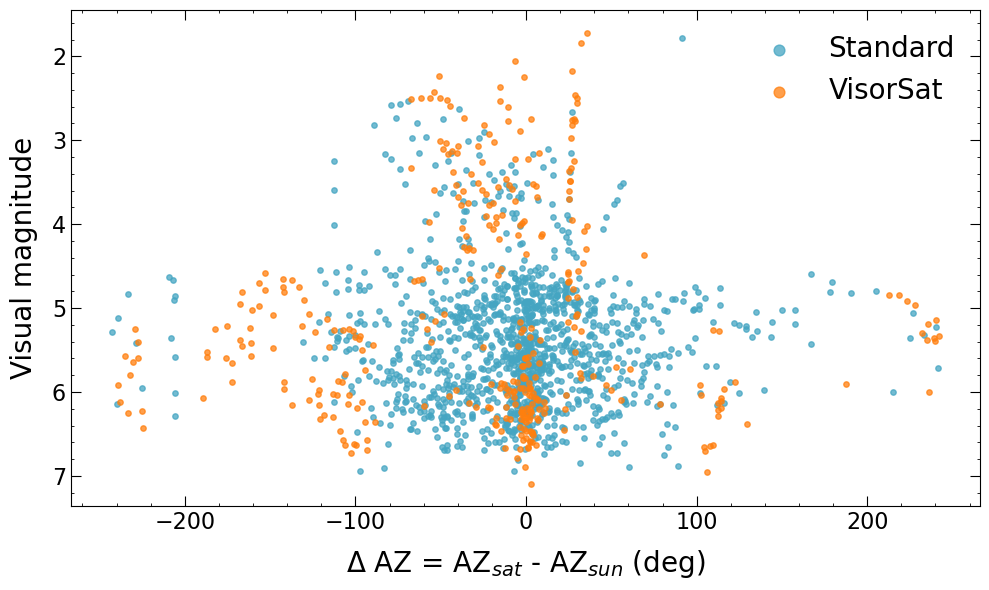

In [173]:
fig, ax = plt.subplots(1, 1, figsize=[10,6])

# THIS IS A GROSS METHOD

# Standard Starlink
idx_standard = [idx for idx, val in enumerate(sat_type) if val == 'standard']
sat_mag_standard = [sat_mag[i] for i in idx_standard] 
sat_az_standard  = [sat_az[i] for i in idx_standard] 
sun_az_standard  = [sun_az[i] for i in idx_standard] 
az_diff_standard = [x - y for (x, y) in zip(sat_az_standard, sun_az_standard)] 

# Visored Starlink
idx_visorsat = [idx for idx, val in enumerate(sat_type) if val == 'visorsat']
sat_mag_visorsat = [sat_mag[i] for i in idx_visorsat] 
sat_az_visorsat  = [sat_az[i] for i in idx_visorsat] 
sun_az_visorsat  = [sun_az[i] for i in idx_visorsat] 
az_diff_visorsat = [x - y for (x, y) in zip(sat_az_visorsat, sun_az_visorsat)] 

ax.scatter(az_diff_standard, sat_mag_standard, c='#44a5c2', s=15, alpha=0.75, label='Standard')
ax.scatter(az_diff_visorsat, sat_mag_visorsat, c='C1', s=15, alpha=0.75, label='VisorSat')

# delta_standard = [sat_delta[i] for i in idx_standard]
# delta_visorsat = [sat_delta[i] for i in idx_visorsat]
# ax.errorbar(az_diff_standard, sat_mag_standard, yerr=delta_standard, c='#44a5c2', fmt='o', markersize=2, alpha=0.75, label='Non-visor')
# ax.errorbar(az_diff_visorsat, sat_mag_visorsat, yerr=delta_visorsat, c='C1', fmt='o', markersize=2, alpha=0.75, label='VisorSat')


leg = ax.legend(fontsize=20, markerscale=2, frameon=False)
ax.invert_yaxis()
print(len(az_diff_standard) + len(az_diff_visorsat) + 2)

ax.minorticks_on()
ax.tick_params(axis='y', which='both', direction='in', right=True)
ax.tick_params(axis='x', which='both', direction='in', top=True)
ax.tick_params(axis='both', which='major', length=7, labelsize=16)
ax.tick_params(axis='both', which='minor', length=2)
ax.set_ylabel('Visual magnitude', labelpad=10, fontsize=20)
ax.set_xlabel(r'$\Delta$ AZ = AZ$_{sat}$ - AZ$_{sun}$ (deg)', fontsize=20, labelpad=10)
    
plt.tight_layout()
plt.savefig(f'{savedir}az_diff.png', dpi=300, bbox_inches='tight')
plt.show()

# should expect to see brightest magnitudes at az_diff = 0

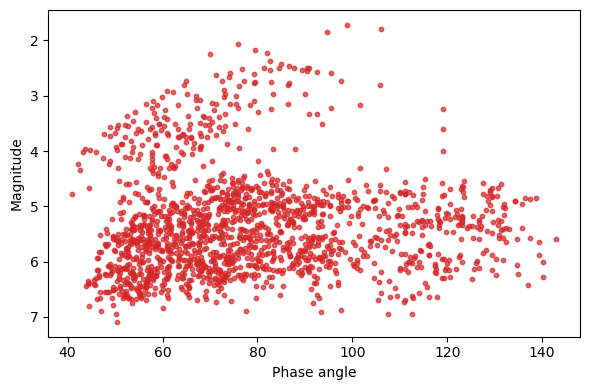

In [48]:
fig, ax = plt.subplots(1, 1, figsize=[6,4])

ax.scatter(phase, sat_mag, s=10, c='C3', alpha=0.7)
ax.invert_yaxis()
ax.set_xlabel('Phase angle')
ax.set_ylabel('Magnitude')
    
plt.tight_layout()    
plt.show()

# Full passages - for some stats

In [45]:
def full_sat_pop_stats():
    
    # AS OF 26 JUNE, LSS is unfinished and LSW has not started ..
    
    df = get_starlink_launches()
    passage_files = sorted(glob.glob(f'{rootdir}passages_all_sats/passages_*.p'))
    passed_files = sorted(glob.glob(f'{rootdir}passages_all_sats/passed_*.p'))
    
    combined_sats = []
    combined_starlinks = []

    for (a,b) in zip(passage_files, passed_files):
        camid = a[-5:-2]
        p = pd.read_pickle(a)
        p_sats = pd.read_pickle(b)
        
        print(camid)

        # JD of first observation
        lstseq0 = list(p.keys())[0]
        sat0 = list(p[lstseq0].keys())[0]
        jd0 = p[lstseq0][sat0]['start']['jd']

        # JD of last observation
        lstseq1 = list(p.keys())[-1]
        sat1 = list(p[lstseq1].keys())[0]
        jd1 = p[lstseq1][sat1]['end']['jd']

        t0 = Time(jd0, format='jd', scale='utc')
        t1 = Time(jd1, format='jd', scale='utc')
        time_diff = t1 - t0
        print(f"Time range spanned: {time_diff.to('hour')} ... {t0.iso} to {t1.iso}")

        all_sats = []
        for lstseq in p.keys():
            all_sats.extend(list(p[lstseq].keys()))

        print('Total number of passed satellites: ', len(all_sats))
        print('Number of unique passed satellites: ', len(np.unique(all_sats)))

        starlink_passages_satnums = []
        for satnum in df.satnum:
            if satnum in p_sats.keys():
                starlink_passages_satnums.append(satnum)

        print('Total number of starlinks passing overhead: ', len(starlink_passages_satnums))
        print('Number of unique starlinks passing overhead: ', len(np.unique(starlink_passages_satnums)))
        print('\n')
        
        combined_sats.extend(all_sats)
        combined_starlinks.extend(starlink_passages_satnums)
    
    print('Across all cameras:')
    print('Combined total number of satellites: ', len(combined_sats))
    print('Combined number of unique satellites: ', len(np.unique(combined_sats)))
    print('\n')
    print('Combined total number of starlinks: ', len(combined_starlinks))
    print('Combined number of unique starlinks: ', len(np.unique(combined_starlinks)))

full_sat_pop_stats()

LSC
Time range spanned: 8.65719048678875 h ... 2022-10-24 00:23:19.418 to 2022-10-24 09:02:45.304
Total number of passed satellites:  557870
Number of unique passed satellites:  7021
Total number of starlinks passing overhead:  880
Number of unique starlinks passing overhead:  880


LSE
Time range spanned: 8.65719049796462 h ... 2022-10-24 00:23:19.418 to 2022-10-24 09:02:45.304
Total number of passed satellites:  1446144
Number of unique passed satellites:  8969
Total number of starlinks passing overhead:  1335
Number of unique starlinks passing overhead:  1335


LSN
Time range spanned: 8.657191067934036 h ... 2022-10-24 00:23:19.417 to 2022-10-24 09:02:45.305
Total number of passed satellites:  2591604
Number of unique passed satellites:  10162
Total number of starlinks passing overhead:  1303
Number of unique starlinks passing overhead:  1303


LSS
Time range spanned: 8.657190531492233 h ... 2022-10-24 00:23:19.419 to 2022-10-24 09:02:45.305
Total number of passed satellites:  55255

### The reason the combined number of unique satellites is so high (14993) is because this includes space debris!

In [176]:
def reduce_passages(camid):
    
    all_passages = pd.read_pickle(f'{fulldata}passages_20221023{camid}.p')
    pool = pd.read_pickle(f'{fulldata}pool_{camid}.p')

    passages = {}
    for lstseq, data in all_passages.items():
        if lstseq in pool:
            passages[lstseq] = {}
            for satnum in pool[lstseq]:
                if satnum in data:
                    passages[lstseq][satnum] = data[satnum]
                    
    return passages

In [203]:
def how_many_starlinks():
    
    starlink_tles = get_tles()
    camids = ['LSC','LSN','LSS','LSE','LSW']
    
    n_images = 0
    img_counts = 0
    all_satnums = []
    for camid in camids: 
        p = reduce_passages(camid)
        
        img_count = 0
        satnums = []
        for lstseq in p.keys():
            if len(list(p[lstseq])) != 0:
                img_count += 1
                satnums.extend(list(p[lstseq]))
          
        print(camid, len(satnums), img_count)
        all_satnums.extend(satnums)
        img_counts += img_count
        n_images += len(p.keys())
    
    print('Total:', len(all_satnums))
    print('Unique:', len(np.unique(all_satnums)))
    print('Number of images:', n_images)
    print('Number of affected images:', img_counts)
    
        

In [204]:
how_many_starlinks()

LSC 496 393
LSN 750 404
LSS 2915 1024
LSE 1468 593
LSW 1870 656
Total: 7499
Unique: 473
Number of images: 3070
Number of affected images: 3070


In [195]:
print(176/473)
print(1605/7499)

0.37209302325581395
0.2140285371382851


In [198]:
print(np.mean(df.delta.values))
print(np.std(df.delta.values))

0.051577700354056406
0.02977267552200554


In [207]:
print(4881*5)
3070/(4881*5)

24405


0.1257938946937103

In [217]:
24405*0.125793894693710

3069.9999999999923

In [218]:
473/4698

0.10068114091102597

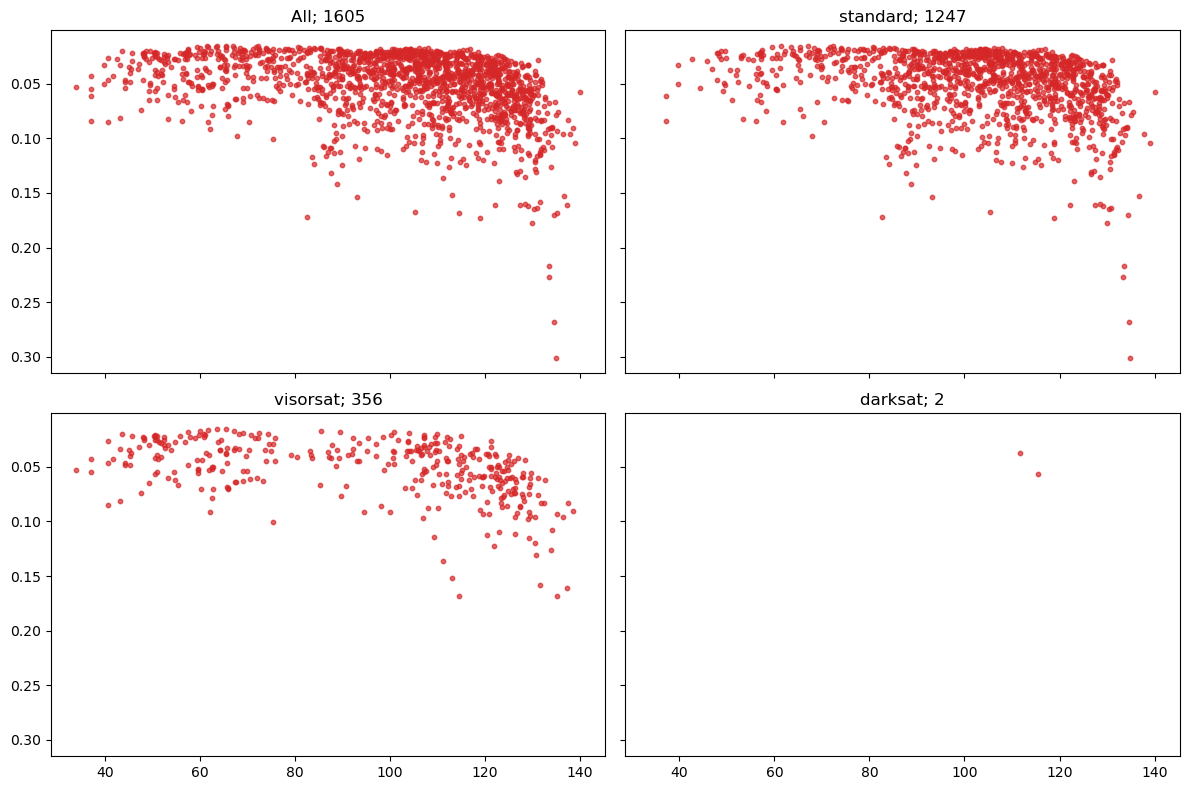

In [219]:
fig, axs = plt.subplots(2, 2, figsize=[12,8], sharey=True, sharex=True)

axs[0,0].scatter(df.phase_angle, df.delta, s=10, c='C3', alpha=0.7)
axs[0,0].set_title(f'All; {len(df)}')
axs[0,0].invert_yaxis()

for sattype, ax in zip(['standard', 'visorsat', 'darksat'], axs.ravel()[1:]):
    ax.scatter(df[df['type']==sattype].phase_angle, df[df['type']==sattype].delta, s=10, c='C3', alpha=0.7)
    ax.set_title(f"{sattype}; {len(df[df['type']==sattype])}")

    
plt.tight_layout()    
plt.show()

In [49]:
max(df.range.values)

1287.172782844512